In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import rasterio as io

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
# # Check if CUDA is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Running on device: {device}')

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    # transforms.ConvertImageDtype(torch.float64)  # Convert input data to double precision
])

In [5]:
# Define dataset class
class CombinedDataset(Dataset):
    def __init__(self, img_dir, target_dir,csv_file, transform=None, mode='train'):
        self.img_dir = img_dir
        self.target_dir = target_dir

        self.csv_data = pd.read_csv(csv_file)
        self.transform = transform
        self.mode = mode


        # List only .tif files for both images and targets
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
        self.target_files = [f for f in os.listdir(target_dir) if f.endswith('.tif')]

        # Optional: Match image files and target files explicitly
        self.image_files = [f for f in self.image_files if f in self.target_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.csv_data.iloc[idx, 1] + ".tif")
        ann_name = os.path.join(self.target_dir, self.csv_data.iloc[idx, 1] + ".tif")
        with io.open(img_name) as src:
            sent2_image = src.read().astype('float32')  # Read image as float64
        
        with io.open(ann_name) as src:
            ann_image = src.read().astype('float32')

        soy_yield_normalized= self.csv_data.iloc[idx, 6]  # First crop yield value
        corn_yield_normalized = self.csv_data.iloc[idx, 7]  # Second crop yield value
        
        if self.transform:
            # image = self.transform(image)
            p=5
        if self.mode == 'test':
            return sent2_image,ann_image, (corn_yield_normalized, soy_yield_normalized)
        else:
            return sent2_image, ann_image, (torch.tensor(corn_yield_normalized, dtype=torch.float32), torch.tensor(soy_yield_normalized, dtype=torch.float32))

In [6]:
img_train = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/img_dir/train_2"
img_val = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/img_dir/val_2"
img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/img_dir/test2"
# img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/img_dir/test6"

ann_train = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/train_2"
ann_val = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/val_2"
ann_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/test2"
# ann_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6"

crop_train = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/train_2/normalized_train_yield.csv"
crop_val = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/val_2/normalized_val_yield.csv"
crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/test2/normalized_test_yield.csv"
# crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6/normalized_test_yield.csv"






In [7]:
dataset_train = CombinedDataset(img_train, ann_train,crop_train, transform=transform)
dataset_val = CombinedDataset(img_val, ann_val,crop_val, transform=transform)
dataset_test = CombinedDataset(img_test, ann_test,crop_test, transform=transform)

In [8]:
# Move data loaders to GPU
train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset_val, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=True, pin_memory=True)
# train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4, collate_fn=None)
# val_loader = DataLoader(dataset_val, batch_size=4, shuffle=False, num_workers=4, collate_fn=None)


In [8]:
# test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True, pin_memory=True)

# for images , targets ,yields in test_loader:
#     # print(name)
#     print(images.shape)
#     print(targets.shape)
#     # print(len(g))
#     print(yields)
   
#     break

In [9]:
class UNetWithYieldEstimation(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetWithYieldEstimation, self).__init__()
        
        # Encoder (Downsampling Path)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder (Upsampling Path)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )
        
        # Adaptive average pooling and additional heads for corn and soybean yield estimation
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_corn = nn.Sequential(
            nn.Linear(128, 64),  # Adjusted to match the output size after pooling
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)
        )
        
        self.fc_soybean = nn.Sequential(
            nn.Linear(128, 64),  # Adjusted to match the output size after pooling
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc_conv1(x)
        x = self.pool1(enc1)
        
        enc2 = self.enc_conv2(x)
        x = self.pool2(enc2)
        
        enc3 = self.enc_conv3(x)
        x = self.pool3(enc3)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder
        x = self.upconv3(x)
        x = torch.cat((x, enc3), dim=1)
        x = self.dec_conv3(x)
        
        x = self.upconv2(x)
        x = torch.cat((x, enc2), dim=1)
        x = self.dec_conv2(x)
        
        x = self.upconv1(x)
        x = torch.cat((x, enc1), dim=1)
        seg_output = self.dec_conv1(x)
        
        # Adaptive average pooling and flatten the bottleneck output for the fully connected layers
        pooled = self.adaptive_pool(x)
        bottleneck_flat = torch.flatten(pooled, start_dim=1)
        
        # Debugging: print shapes
        # print("Shape before pooling:", x.shape)
        # print("Shape after pooling:", pooled.shape)
        # print("Shape after flattening:", bottleneck_flat.shape)
        
        # Predict corn and soybean yields
        corn_yield = self.fc_corn(bottleneck_flat)
        soybean_yield = self.fc_soybean(bottleneck_flat)
        
        # corn_yield = torch.sigmoid(self.fc_corn(bottleneck_flat))
        # soybean_yield = torch.sigmoid(self.fc_soybean(bottleneck_flat))

        return seg_output, corn_yield, soybean_yield


In [ ]:
# train with sigmoid

In [2]:
# import os
# import pandas as pd
# from torch.utils.data import Dataset
# import torch
# from torchvision import transforms
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import r2_score
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm


# # Check if CUDA is available and set the default device accordingly
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Using device: {device}')

# # Assuming UNetWithYieldEstimation and other necessary elements are defined
# model = UNetWithYieldEstimation(in_channels=8, out_channels=3).to(device)
# model = nn.DataParallel(model)

# # Define loss functions
# criterion_segmentation = nn.CrossEntropyLoss()
# criterion_regression = nn.MSELoss()

# # Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# # Define the learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# # Define Early Stopping
# class EarlyStopping:
#     def __init__(self, patience=10, verbose=False, delta=0, checkpoint_dir='checkpoints_unet_sigmoid'):
#         self.patience = patience
#         self.verbose = verbose
#         self.delta = delta
#         self.best_score = None
#         self.early_stop = False
#         self.val_loss_min = float('inf')
#         self.counter = 0
#         self.checkpoint_dir = checkpoint_dir

#         if not os.path.exists(self.checkpoint_dir):
#             os.makedirs(self.checkpoint_dir)

#     def __call__(self, val_loss, model, optimizer, epoch):
#         score = -val_loss
#         if self.best_score is None:
#             self.best_score = score
#             self.save_checkpoint(val_loss, model, optimizer, epoch)
#         elif score < self.best_score + self.delta:
#             self.counter += 1
#             print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.save_checkpoint(val_loss, model, optimizer, epoch)
#             self.counter = 0

#     def save_checkpoint(self, val_loss, model, optimizer, epoch):
#         """Saves model and optimizer when validation loss decreases."""
#         if self.verbose:
#             print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
#         checkpoint_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.module.state_dict(),  # Access the underlying model
#             'optimizer_state_dict': optimizer.state_dict(),
#             'val_loss': val_loss
#         }, checkpoint_path)
#         self.val_loss_min = val_loss

# early_stopper = EarlyStopping(patience=10, verbose=True)

# # Define the number of epochs
# num_epochs = 50

# # Initialize lists to store losses and R² scores
# train_losses_seg, val_losses_seg = [], []
# train_losses_corn, val_losses_corn = [], []
# train_losses_soybean, val_losses_soybean = [], []
# train_r2_corn, val_r2_corn = [], []
# train_r2_soybean, val_r2_soybean = [], []
# train_ious, val_ious = [],[]

# # Function to calculate IoU
# def calculate_iou(preds, targets, num_classes=3):
#     ious = []
#     preds = torch.argmax(preds, dim=1).view(-1)
#     targets = targets.view(-1)

#     for cls in range(num_classes):
#         pred_inds = preds == cls
#         target_inds = targets == cls
#         intersection = (pred_inds & target_inds).long().sum().item()
#         union = (pred_inds | target_inds).long().sum().item()

#         if union == 0:
#             ious.append(float('nan'))
#         else:
#             ious.append(intersection / union)

#     return np.nanmean(ious)  # Average IoU across classes

# # Function to get current learning rate
# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

# # Plotting functions
# def plot_losses(train_losses, val_losses, loss_type, filename):
#     epochs = range(1, len(train_losses) + 1)
#     plt.figure(figsize=(10, 6))
#     plt.plot(epochs, train_losses, 'b', label=f'Training {loss_type} Loss')
#     plt.plot(epochs, val_losses, 'r', label=f'Validation {loss_type} Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel(f'{loss_type} Loss')
#     plt.legend()
#     plt.title(f'Training and Validation {loss_type} Loss')
#     plt.grid(True)
#     plt.savefig(filename)
#     plt.show()

# def plot_r2_scores(train_r2, val_r2, crop_type, filename):
#     epochs = range(1, len(train_r2) + 1)
#     plt.figure(figsize=(10, 6))
#     plt.plot(epochs, train_r2, 'b', label=f'Training {crop_type} R^2 Score')
#     plt.plot(epochs, val_r2, 'r', label=f'Validation {crop_type} R^2 Score')
#     plt.xlabel('Epochs')
#     plt.ylabel(f'{crop_type} R^2 Score')
#     plt.legend()
#     plt.title(f'Training and Validation {crop_type} R^2 Score')
#     plt.grid(True)
#     plt.savefig(filename)
#     plt.show()

# def plot_iou(train_iou, val_iou, filename):
#     epochs = range(1, len(train_iou) + 1)
#     plt.figure(figsize=(10, 6))
#     plt.plot(epochs, train_iou, 'b', label='Training IoU')
#     plt.plot(epochs, val_iou, 'r', label='Validation IoU')
#     plt.xlabel('Epochs')
#     plt.ylabel('IoU')
#     plt.legend()
#     plt.title('Training and Validation IoU')
#     plt.grid(True)
#     plt.savefig(filename)
#     plt.show()

# # Training and validation loop
# with open('checkpoints_unet_sigmoid/loss_log_unet_sigmoid.txt', 'w') as f:
#     f.write("Epoch,Train Seg Loss,Train IoU,Val Seg Loss,Val IoU,Train Corn Loss,Train Soybean Loss,Val Corn Loss,Val Soybean Loss,Train Corn R2,Train Soybean R2,Val Corn R2,Val Soybean R2,Learning Rate\n")

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss_seg, train_iou = 0.0, 0.0
#         train_loss_corn, train_loss_soybean = 0.0, 0.0
#         total_train_r2_corn, total_train_r2_soybean = 0.0, 0.0
#         for images, targets, yields in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
#             corn_yield, soybean_yield = yields
#             images, targets = images.to(device).float(), targets.to(device).long()
#             corn_yield, soybean_yield = corn_yield.to(device), soybean_yield.to(device)

#             optimizer.zero_grad()
#             seg_output, pred_corn_yield, pred_soybean_yield = model(images)

#             loss_segmentation = criterion_segmentation(seg_output, targets.squeeze(1))  # Squeeze the targets
#             loss_corn_yield = criterion_regression(pred_corn_yield.view(-1), corn_yield)
#             loss_soybean_yield = criterion_regression(pred_soybean_yield.view(-1), soybean_yield)

#             loss = loss_segmentation + loss_corn_yield + loss_soybean_yield
#             loss.backward()
#             optimizer.step()

#             train_loss_seg += loss_segmentation.item()
#             train_loss_corn += loss_corn_yield.item()
#             train_loss_soybean += loss_soybean_yield.item()
#             train_iou += calculate_iou(seg_output, targets)
#             total_train_r2_corn += r2_score(corn_yield.cpu().numpy(), pred_corn_yield.view(-1).cpu().detach().numpy())
#             total_train_r2_soybean += r2_score(soybean_yield.cpu().numpy(), pred_soybean_yield.view(-1).cpu().detach().numpy())

#         train_losses_seg.append(train_loss_seg / len(train_loader))
#         train_ious.append(train_iou / len(train_loader))
#         train_losses_corn.append(train_loss_corn / len(train_loader))
#         train_losses_soybean.append(train_loss_soybean / len(train_loader))
#         train_r2_corn.append(total_train_r2_corn / len(train_loader))
#         train_r2_soybean.append(total_train_r2_soybean / len(train_loader))

#         model.eval()
#         val_loss_seg, val_iou = 0.0, 0.0
#         val_loss_corn, val_loss_soybean = 0.0, 0.0
#         total_val_r2_corn, total_val_r2_soybean = 0.0, 0.0
#         with torch.no_grad():
#             for images, targets, yields in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
#                 corn_yield, soybean_yield = yields
#                 images, targets = images.to(device).float(), targets.to(device).long()
#                 corn_yield, soybean_yield = corn_yield.to(device), soybean_yield.to(device)

#                 seg_output, pred_corn_yield, pred_soybean_yield = model(images)

#                 loss_segmentation = criterion_segmentation(seg_output, targets.squeeze(1))  # Squeeze the targets
#                 loss_corn_yield = criterion_regression(pred_corn_yield.view(-1), corn_yield)
#                 loss_soybean_yield = criterion_regression(pred_soybean_yield.view(-1), soybean_yield)

#                 loss = loss_segmentation + loss_corn_yield + loss_soybean_yield
#                 val_loss_seg += loss_segmentation.item()
#                 val_loss_corn += loss_corn_yield.item()
#                 val_loss_soybean += loss_soybean_yield.item()
#                 val_iou += calculate_iou(seg_output, targets)
#                 total_val_r2_corn += r2_score(corn_yield.cpu().numpy(), pred_corn_yield.view(-1).cpu().detach().numpy())
#                 total_val_r2_soybean += r2_score(soybean_yield.cpu().numpy(), pred_soybean_yield.view(-1).cpu().detach().numpy())

#         val_losses_seg.append(val_loss_seg / len(val_loader))
#         val_ious.append(val_iou / len(val_loader))
#         val_losses_corn.append(val_loss_corn / len(val_loader))
#         val_losses_soybean.append(val_loss_soybean / len(val_loader))
#         val_r2_corn.append(total_val_r2_corn / len(val_loader))
#         val_r2_soybean.append(total_val_r2_soybean / len(val_loader))

#         current_lr = get_lr(optimizer)

#         print(f'Epoch {epoch+1}, Train Seg Loss: {train_losses_seg[-1]:.4f}, Train IoU: {train_ious[-1]:.4f}, Val Seg Loss: {val_losses_seg[-1]:.4f}, Val IoU: {val_ious[-1]:.4f}')
#         print(f'          Train Corn Loss: {train_losses_corn[-1]:.4f}, Train Soybean Loss: {train_losses_soybean[-1]:.4f}')
#         print(f'          Val Corn Loss: {val_losses_corn[-1]:.4f}, Val Soybean Loss: {val_losses_soybean[-1]:.4f}')
#         print(f'          Train Corn R2: {train_r2_corn[-1]:.4f}, Train Soybean R2: {train_r2_soybean[-1]:.4f}')
#         print(f'          Val Corn R2: {val_r2_corn[-1]:.4f}, Val Soybean R2: {val_r2_soybean[-1]:.4f}')
#         print(f'          Learning Rate: {current_lr:.6f}')

#         f.write(f"{epoch+1},{train_losses_seg[-1]:.4f},{train_ious[-1]:.4f},{val_losses_seg[-1]:.4f},{val_ious[-1]:.4f},{train_losses_corn[-1]:.4f},{train_losses_soybean[-1]:.4f},{val_losses_corn[-1]:.4f},{val_losses_soybean[-1]:.4f},{train_r2_corn[-1]:.4f},{train_r2_soybean[-1]:.4f},{val_r2_corn[-1]:.4f},{val_r2_soybean[-1]:.4f},{current_lr:.6f}\n")

#         # Save checkpoint every epoch
#         early_stopper.save_checkpoint(val_losses_seg[-1], model, optimizer, epoch)

#         # Step the scheduler
#         scheduler.step(val_losses_seg[-1])

#         # Early stopping check
#         early_stopper(val_losses_seg[-1], model, optimizer, epoch)
#         if early_stopper.early_stop:
#             print("Early stopping triggered.")
#             break

# # Plotting the losses and R2 scores
# plot_losses(train_losses_seg, val_losses_seg, 'Segmentation', 'checkpoints_unet_sigmoid/train_val_segmentation_loss.png')
# plot_losses(train_losses_corn, val_losses_corn, 'Corn', 'checkpoints_unet_sigmoid/train_val_corn_loss.png')
# plot_losses(train_losses_soybean, val_losses_soybean, 'Soybean', 'checkpoints_unet_sigmoid/train_val_soybean_loss.png')
# plot_r2_scores(train_r2_corn, val_r2_corn, 'Corn', 'checkpoints_unet_sigmoid/train_val_corn_r2.png')
# plot_r2_scores(train_r2_soybean, val_r2_soybean, 'Soybean', 'checkpoints_unet_sigmoid/train_val_soybean_r2.png')
# plot_iou(train_ious, val_ious, 'checkpoints_unet_sigmoid/train_val_iou.png')


In [ ]:
# Test on Minnesota 22

In [1]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import r2_score
# import pandas as pd  # Add this import

# def load_checkpoint(model, checkpoint_path, device):
#     checkpoint = torch.load(checkpoint_path, map_location=device)
#     state_dict = checkpoint['model_state_dict']

#     # Check if the model is wrapped in nn.DataParallel
#     if 'module.' in list(state_dict.keys())[0]:
#         new_state_dict = {}
#         for k, v in state_dict.items():
#             if k.startswith('module.'):
#                 new_state_dict[k[7:]] = v
#             else:
#                 new_state_dict[k] = v
#         model.load_state_dict(new_state_dict)
#     else:
#         # Model was not wrapped in nn.DataParallel during training
#         new_state_dict = {}
#         for k, v in state_dict.items():
#             new_state_dict[f'module.{k}'] = v
#         model.load_state_dict(new_state_dict)

#     print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.4f}")

# def pixel_accuracy(output, target):
#     _, predicted = torch.max(output, 1)
#     correct = (predicted == target).sum().item()
#     total = target.numel()
#     return correct / total

# def mean_pixel_accuracy(output, target, num_classes):
#     _, predicted = torch.max(output, 1)
#     mean_acc = 0
#     for i in range(num_classes):
#         class_mask = (target == i)
#         correct = ((predicted == i) & class_mask).sum().item()
#         total = class_mask.sum().item()
#         if total == 0:
#             continue
#         mean_acc += correct / total
#     return mean_acc / num_classes

# def dice_coefficient(output, target, num_classes=3):
#     smooth = 1e-6
#     _, predicted = torch.max(output, 1)
#     dice = 0.0

#     for i in range(num_classes):
#         pred_i = (predicted == i).float()
#         target_i = (target == i).float()
#         intersection = (pred_i * target_i).sum().item()
#         union = pred_i.sum().item() + target_i.sum().item()
#         dice += (2. * intersection + smooth) / (union + smooth)
    
#     return dice / num_classes

# def evaluate_model(model, test_loader, device):
#     model.eval()

#     # Define metrics to track
#     test_loss = 0.0
#     test_iou = 0.0
#     test_pixel_acc = 0.0
#     test_mean_pixel_acc = 0.0
#     test_dice = 0.0
#     test_corn_loss = 0.0
#     test_soybean_loss = 0.0
#     test_segmentation_criterion = nn.CrossEntropyLoss()
#     test_regression_criterion = nn.MSELoss()
#     num_classes = 3  # Adjust based on your specific number of classes

#     # Tracking arrays for yield predictions and actual yields
#     all_pred_corn_yields = []
#     all_true_corn_yields = []
#     all_pred_soybean_yields = []
#     all_true_soybean_yields = []

#     # Add index tracking
#     indices = []

#     # Testing loop
#     with torch.no_grad():
#         for idx, (images, targets, yields) in enumerate(test_loader):
#             corn_yield, soybean_yield = yields
#             images, targets = images.to(device).float(), targets.to(device).long()
#             corn_yield, soybean_yield = corn_yield.to(device), soybean_yield.to(device)

#             # Remove the channel dimension from targets
#             targets = targets.squeeze(1)

#             seg_output, pred_corn_yield, pred_soybean_yield = model(images)

#             # Ensure predicted yields retain their dimensions
#             pred_corn_yield = pred_corn_yield.view(-1)
#             pred_soybean_yield = pred_soybean_yield.view(-1)

#             loss_segmentation = test_segmentation_criterion(seg_output, targets)
#             loss_corn_yield = test_regression_criterion(pred_corn_yield, corn_yield)
#             loss_soybean_yield = test_regression_criterion(pred_soybean_yield, soybean_yield)

#             loss = loss_segmentation +  loss_corn_yield +  loss_soybean_yield
#             test_loss += loss.item()
#             test_iou += calculate_iou(seg_output, targets)
#             test_pixel_acc += pixel_accuracy(seg_output, targets)
#             test_mean_pixel_acc += mean_pixel_accuracy(seg_output, targets, num_classes)
#             test_dice += dice_coefficient(seg_output, targets)
#             test_corn_loss += loss_corn_yield.item()
#             test_soybean_loss += loss_soybean_yield.item()

#             # Store predictions, actual yields, and indices
#             all_pred_corn_yields.extend(pred_corn_yield.cpu().numpy())
#             all_true_corn_yields.extend(corn_yield.cpu().numpy())
#             all_pred_soybean_yields.extend(pred_soybean_yield.cpu().numpy())
#             all_true_soybean_yields.extend(soybean_yield.cpu().numpy())
#             indices.extend([idx] * len(pred_corn_yield))

#     # Calculate average test loss and metrics
#     test_loss /= len(test_loader)
#     test_iou /= len(test_loader)
#     test_pixel_acc /= len(test_loader)
#     test_mean_pixel_acc /= len(test_loader)
#     test_dice /= len(test_loader)
#     test_corn_loss /= len(test_loader)
#     test_soybean_loss /= len(test_loader)

#     print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')
#     print(f'Test Pixel Accuracy: {test_pixel_acc:.4f}')
#     print(f'Test Mean Pixel Accuracy: {test_mean_pixel_acc:.4f}')
#     print(f'Test Dice Coefficient: {test_dice:.4f}')
#     print(f'Test Corn Loss: {test_corn_loss:.4f}')
#     print(f'Test Soybean Loss: {test_soybean_loss:.4f}')

#     # Calculate R² score for yield predictions
#     r2_corn = r2_score(all_true_corn_yields, all_pred_corn_yields)
#     r2_soybean = r2_score(all_true_soybean_yields, all_pred_soybean_yields)

#     print(f'R^2 Score for Corn Yield: {r2_corn:.4f}')
#     print(f'R^2 Score for Soybean Yield: {r2_soybean:.4f}')

#     # Save predictions to CSV
#     results_df = pd.DataFrame({
#         'Index': indices,
#         'True_Corn_Yield': all_true_corn_yields,
#         'Predicted_Corn_Yield': all_pred_corn_yields,
#         'True_Soybean_Yield': all_true_soybean_yields,
#         'Predicted_Soybean_Yield': all_pred_soybean_yields
#     })
#     results_df.to_csv('checkpoints_unet_no_sig/predictions_unet_no_seg.csv', index=False)

#     return (all_true_corn_yields, all_pred_corn_yields,
#             all_true_soybean_yields, all_pred_soybean_yields,
#             r2_corn, r2_soybean)

# def plot_scatter(true_values, pred_values, crop_type, filename):
#     plt.figure(figsize=(10, 6))
#     color = 'orange' if crop_type == 'Corn' else 'blue'
#     plt.scatter(true_values, pred_values, color=color, alpha=0.5)
#     plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', linewidth=2)
#     plt.title(f'Scatter Plot of Test Labels vs Test Outputs ({crop_type})')
#     plt.xlabel(f'Test Labels ({crop_type})')
#     plt.ylabel(f'Test Outputs ({crop_type})')
#     plt.grid(True)
#     plt.savefig(filename)
#     plt.show()

# def plot_r2_scores(r2_corn, r2_soybean, filename):
#     crops = ['Corn', 'Soybean']
#     r2_scores = [r2_corn, r2_soybean]
    
#     plt.figure(figsize=(10, 6))
#     bars = plt.bar(crops, r2_scores, color=['orange', 'blue'])
#     plt.xlabel('Crops')
#     plt.ylabel('R² Score')
#     plt.title('R² Scores for Corn and Soybean Yields')
    
#     for bar in bars:
#         yval = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')
    
#     plt.ylim(0, 1)  # Set y-axis limit to range [0, 1]
#     plt.grid(True)
#     plt.savefig(filename)
#     plt.show()

# # Assuming 'model', 'test_loader', 'device' are defined, and the model is already loaded with the best weights
# model = UNetWithYieldEstimation(in_channels=8, out_channels=3).to(device)
# model = nn.DataParallel(model)
# checkpoint_path = 'checkpoints_unet_no_sig/checkpoint_epoch_49.pth'
# load_checkpoint(model, checkpoint_path, device)

# (all_true_corn_yields, all_pred_corn_yields,
#  all_true_soybean_yields, all_pred_soybean_yields,
#  r2_corn, r2_soybean) = evaluate_model(model, test_loader, device)

# # Plot the results
# plot_scatter(all_true_corn_yields, all_pred_corn_yields, 'Corn', 'checkpoints_unet_no_sig/test_labels_vs_outputs_corn.png')
# plot_scatter(all_true_soybean_yields, all_pred_soybean_yields, 'Soybean', 'checkpoints_unet_no_sig/test_labels_vs_outputs_soybean.png')
# plot_r2_scores(r2_corn, r2_soybean, 'checkpoints_unet_no_sig/test_r2_scores.png')


In [ ]:
# train without sigmoid

Using device: cuda


Validation Epoch 1/50: 100%|██████████| 19/19 [00:27<00:00,  1.44s/it]


Epoch 1, Train Seg Loss: 1.0895, Train IoU: 0.1341, Val Seg Loss: 1.0835, Val IoU: 0.1324
          Train Corn Loss: 0.0586, Train Soybean Loss: 0.0701
          Val Corn Loss: 0.0393, Val Soybean Loss: 0.0288
          Train Corn R2: -0.4378, Train Soybean R2: -1.2207
          Val Corn R2: 0.0419, Val Soybean R2: 0.0958
          Learning Rate: 0.000100
Validation loss decreased (inf --> 1.083467). Saving model ...
Validation loss decreased (1.083467 --> 1.083467). Saving model ...


Validation Epoch 2/50: 100%|██████████| 19/19 [00:30<00:00,  1.58s/it]


Epoch 2, Train Seg Loss: 1.0402, Train IoU: 0.2295, Val Seg Loss: 0.9619, Val IoU: 0.4044
          Train Corn Loss: 0.0385, Train Soybean Loss: 0.0282
          Val Corn Loss: 0.0385, Val Soybean Loss: 0.0289
          Train Corn R2: 0.0609, Train Soybean R2: 0.1027
          Val Corn R2: 0.0607, Val Soybean R2: 0.0918
          Learning Rate: 0.000100
Validation loss decreased (1.083467 --> 0.961867). Saving model ...
Validation loss decreased (0.961867 --> 0.961867). Saving model ...


Validation Epoch 3/50: 100%|██████████| 19/19 [00:27<00:00,  1.44s/it]


Epoch 3, Train Seg Loss: 0.9065, Train IoU: 0.3822, Val Seg Loss: 0.8702, Val IoU: 0.3619
          Train Corn Loss: 0.0366, Train Soybean Loss: 0.0277
          Val Corn Loss: 0.0340, Val Soybean Loss: 0.0266
          Train Corn R2: 0.1115, Train Soybean R2: 0.1218
          Val Corn R2: 0.1652, Val Soybean R2: 0.1605
          Learning Rate: 0.000100
Validation loss decreased (0.961867 --> 0.870220). Saving model ...
Validation loss decreased (0.870220 --> 0.870220). Saving model ...


Validation Epoch 4/50: 100%|██████████| 19/19 [00:23<00:00,  1.24s/it]


Epoch 4, Train Seg Loss: 0.8456, Train IoU: 0.4039, Val Seg Loss: 0.8121, Val IoU: 0.4975
          Train Corn Loss: 0.0327, Train Soybean Loss: 0.0253
          Val Corn Loss: 0.0306, Val Soybean Loss: 0.0250
          Train Corn R2: 0.2034, Train Soybean R2: 0.1953
          Val Corn R2: 0.2572, Val Soybean R2: 0.2139
          Learning Rate: 0.000100
Validation loss decreased (0.870220 --> 0.812114). Saving model ...
Validation loss decreased (0.812114 --> 0.812114). Saving model ...


Validation Epoch 5/50: 100%|██████████| 19/19 [00:30<00:00,  1.62s/it]


Epoch 5, Train Seg Loss: 0.7602, Train IoU: 0.5029, Val Seg Loss: 0.6730, Val IoU: 0.5774
          Train Corn Loss: 0.0286, Train Soybean Loss: 0.0242
          Val Corn Loss: 0.0251, Val Soybean Loss: 0.0252
          Train Corn R2: 0.3070, Train Soybean R2: 0.2316
          Val Corn R2: 0.3786, Val Soybean R2: 0.2150
          Learning Rate: 0.000100
Validation loss decreased (0.812114 --> 0.673026). Saving model ...
Validation loss decreased (0.673026 --> 0.673026). Saving model ...


Validation Epoch 6/50: 100%|██████████| 19/19 [00:25<00:00,  1.36s/it]


Epoch 6, Train Seg Loss: 0.6378, Train IoU: 0.5872, Val Seg Loss: 0.6140, Val IoU: 0.6035
          Train Corn Loss: 0.0208, Train Soybean Loss: 0.0247
          Val Corn Loss: 0.0171, Val Soybean Loss: 0.0241
          Train Corn R2: 0.4913, Train Soybean R2: 0.2117
          Val Corn R2: 0.5850, Val Soybean R2: 0.2460
          Learning Rate: 0.000100
Validation loss decreased (0.673026 --> 0.614046). Saving model ...
Validation loss decreased (0.614046 --> 0.614046). Saving model ...


Validation Epoch 7/50: 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


Epoch 7, Train Seg Loss: 0.5806, Train IoU: 0.6195, Val Seg Loss: 0.5576, Val IoU: 0.6331
          Train Corn Loss: 0.0149, Train Soybean Loss: 0.0230
          Val Corn Loss: 0.0125, Val Soybean Loss: 0.0242
          Train Corn R2: 0.6343, Train Soybean R2: 0.2663
          Val Corn R2: 0.6957, Val Soybean R2: 0.2550
          Learning Rate: 0.000100
Validation loss decreased (0.614046 --> 0.557628). Saving model ...
Validation loss decreased (0.557628 --> 0.557628). Saving model ...


Validation Epoch 8/50: 100%|██████████| 19/19 [00:24<00:00,  1.27s/it]


Epoch 8, Train Seg Loss: 0.5280, Train IoU: 0.6511, Val Seg Loss: 0.5267, Val IoU: 0.6453
          Train Corn Loss: 0.0122, Train Soybean Loss: 0.0219
          Val Corn Loss: 0.0129, Val Soybean Loss: 0.0223
          Train Corn R2: 0.7009, Train Soybean R2: 0.3032
          Val Corn R2: 0.6788, Val Soybean R2: 0.3059
          Learning Rate: 0.000100
Validation loss decreased (0.557628 --> 0.526688). Saving model ...
Validation loss decreased (0.526688 --> 0.526688). Saving model ...


Validation Epoch 9/50: 100%|██████████| 19/19 [00:22<00:00,  1.20s/it]


Epoch 9, Train Seg Loss: 0.4907, Train IoU: 0.6746, Val Seg Loss: 0.4796, Val IoU: 0.6796
          Train Corn Loss: 0.0105, Train Soybean Loss: 0.0208
          Val Corn Loss: 0.0089, Val Soybean Loss: 0.0212
          Train Corn R2: 0.7450, Train Soybean R2: 0.3411
          Val Corn R2: 0.7770, Val Soybean R2: 0.3374
          Learning Rate: 0.000100
Validation loss decreased (0.526688 --> 0.479574). Saving model ...
Validation loss decreased (0.479574 --> 0.479574). Saving model ...


Validation Epoch 10/50: 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]


Epoch 10, Train Seg Loss: 0.4560, Train IoU: 0.7013, Val Seg Loss: 0.4242, Val IoU: 0.7260
          Train Corn Loss: 0.0088, Train Soybean Loss: 0.0192
          Val Corn Loss: 0.0073, Val Soybean Loss: 0.0180
          Train Corn R2: 0.7837, Train Soybean R2: 0.3908
          Val Corn R2: 0.8224, Val Soybean R2: 0.4321
          Learning Rate: 0.000100
Validation loss decreased (0.479574 --> 0.424200). Saving model ...
Validation loss decreased (0.424200 --> 0.424200). Saving model ...


Validation Epoch 11/50: 100%|██████████| 19/19 [00:22<00:00,  1.18s/it]


Epoch 11, Train Seg Loss: 0.4205, Train IoU: 0.7280, Val Seg Loss: 0.4309, Val IoU: 0.7199
          Train Corn Loss: 0.0078, Train Soybean Loss: 0.0162
          Val Corn Loss: 0.0069, Val Soybean Loss: 0.0160
          Train Corn R2: 0.8091, Train Soybean R2: 0.4866
          Val Corn R2: 0.8314, Val Soybean R2: 0.5012
          Learning Rate: 0.000100
Validation loss decreased (0.424200 --> 0.430920). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 12/50: 100%|██████████| 19/19 [00:23<00:00,  1.23s/it]


Epoch 12, Train Seg Loss: 0.3954, Train IoU: 0.7452, Val Seg Loss: 0.3765, Val IoU: 0.7601
          Train Corn Loss: 0.0071, Train Soybean Loss: 0.0134
          Val Corn Loss: 0.0064, Val Soybean Loss: 0.0122
          Train Corn R2: 0.8264, Train Soybean R2: 0.5715
          Val Corn R2: 0.8445, Val Soybean R2: 0.6207
          Learning Rate: 0.000100
Validation loss decreased (0.430920 --> 0.376488). Saving model ...
Validation loss decreased (0.376488 --> 0.376488). Saving model ...


Validation Epoch 13/50: 100%|██████████| 19/19 [00:25<00:00,  1.32s/it]


Epoch 13, Train Seg Loss: 0.3783, Train IoU: 0.7567, Val Seg Loss: 0.3597, Val IoU: 0.7702
          Train Corn Loss: 0.0069, Train Soybean Loss: 0.0115
          Val Corn Loss: 0.0065, Val Soybean Loss: 0.0092
          Train Corn R2: 0.8311, Train Soybean R2: 0.6345
          Val Corn R2: 0.8365, Val Soybean R2: 0.7123
          Learning Rate: 0.000100
Validation loss decreased (0.376488 --> 0.359745). Saving model ...
Validation loss decreased (0.359745 --> 0.359745). Saving model ...


Validation Epoch 14/50: 100%|██████████| 19/19 [00:25<00:00,  1.33s/it]


Epoch 14, Train Seg Loss: 0.3555, Train IoU: 0.7717, Val Seg Loss: 0.3616, Val IoU: 0.7679
          Train Corn Loss: 0.0058, Train Soybean Loss: 0.0092
          Val Corn Loss: 0.0061, Val Soybean Loss: 0.0103
          Train Corn R2: 0.8569, Train Soybean R2: 0.7033
          Val Corn R2: 0.8526, Val Soybean R2: 0.6810
          Learning Rate: 0.000100
Validation loss decreased (0.359745 --> 0.361559). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 15/50: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Epoch 15, Train Seg Loss: 0.3428, Train IoU: 0.7797, Val Seg Loss: 0.3348, Val IoU: 0.7864
          Train Corn Loss: 0.0053, Train Soybean Loss: 0.0082
          Val Corn Loss: 0.0046, Val Soybean Loss: 0.0077
          Train Corn R2: 0.8697, Train Soybean R2: 0.7351
          Val Corn R2: 0.8865, Val Soybean R2: 0.7491
          Learning Rate: 0.000100
Validation loss decreased (0.361559 --> 0.334773). Saving model ...
Validation loss decreased (0.334773 --> 0.334773). Saving model ...


Validation Epoch 16/50: 100%|██████████| 19/19 [00:27<00:00,  1.45s/it]


Epoch 16, Train Seg Loss: 0.3464, Train IoU: 0.7764, Val Seg Loss: 0.3203, Val IoU: 0.7939
          Train Corn Loss: 0.0047, Train Soybean Loss: 0.0093
          Val Corn Loss: 0.0039, Val Soybean Loss: 0.0060
          Train Corn R2: 0.8835, Train Soybean R2: 0.7000
          Val Corn R2: 0.9035, Val Soybean R2: 0.8143
          Learning Rate: 0.000100
Validation loss decreased (0.334773 --> 0.320254). Saving model ...
Validation loss decreased (0.320254 --> 0.320254). Saving model ...


Validation Epoch 17/50: 100%|██████████| 19/19 [00:27<00:00,  1.42s/it]


Epoch 17, Train Seg Loss: 0.3173, Train IoU: 0.7955, Val Seg Loss: 0.3094, Val IoU: 0.8010
          Train Corn Loss: 0.0041, Train Soybean Loss: 0.0062
          Val Corn Loss: 0.0036, Val Soybean Loss: 0.0055
          Train Corn R2: 0.8989, Train Soybean R2: 0.8030
          Val Corn R2: 0.9109, Val Soybean R2: 0.8245
          Learning Rate: 0.000100
Validation loss decreased (0.320254 --> 0.309366). Saving model ...
Validation loss decreased (0.309366 --> 0.309366). Saving model ...


Validation Epoch 18/50: 100%|██████████| 19/19 [00:26<00:00,  1.41s/it]


Epoch 18, Train Seg Loss: 0.3193, Train IoU: 0.7940, Val Seg Loss: 0.3213, Val IoU: 0.7907
          Train Corn Loss: 0.0040, Train Soybean Loss: 0.0069
          Val Corn Loss: 0.0036, Val Soybean Loss: 0.0068
          Train Corn R2: 0.9001, Train Soybean R2: 0.7816
          Val Corn R2: 0.9110, Val Soybean R2: 0.7887
          Learning Rate: 0.000100
Validation loss decreased (0.309366 --> 0.321349). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 19/50: 100%|██████████| 19/19 [00:25<00:00,  1.35s/it]


Epoch 19, Train Seg Loss: 0.3177, Train IoU: 0.7948, Val Seg Loss: 0.3008, Val IoU: 0.8055
          Train Corn Loss: 0.0038, Train Soybean Loss: 0.0068
          Val Corn Loss: 0.0035, Val Soybean Loss: 0.0051
          Train Corn R2: 0.9071, Train Soybean R2: 0.7841
          Val Corn R2: 0.9157, Val Soybean R2: 0.8423
          Learning Rate: 0.000100
Validation loss decreased (0.321349 --> 0.300827). Saving model ...
Validation loss decreased (0.300827 --> 0.300827). Saving model ...


Validation Epoch 20/50: 100%|██████████| 19/19 [00:28<00:00,  1.50s/it]


Epoch 20, Train Seg Loss: 0.3064, Train IoU: 0.8016, Val Seg Loss: 0.2967, Val IoU: 0.8074
          Train Corn Loss: 0.0032, Train Soybean Loss: 0.0057
          Val Corn Loss: 0.0030, Val Soybean Loss: 0.0047
          Train Corn R2: 0.9212, Train Soybean R2: 0.8169
          Val Corn R2: 0.9277, Val Soybean R2: 0.8541
          Learning Rate: 0.000100
Validation loss decreased (0.300827 --> 0.296729). Saving model ...
Validation loss decreased (0.296729 --> 0.296729). Saving model ...


Validation Epoch 21/50: 100%|██████████| 19/19 [00:33<00:00,  1.78s/it]


Epoch 21, Train Seg Loss: 0.2966, Train IoU: 0.8080, Val Seg Loss: 0.3123, Val IoU: 0.7979
          Train Corn Loss: 0.0028, Train Soybean Loss: 0.0049
          Val Corn Loss: 0.0029, Val Soybean Loss: 0.0072
          Train Corn R2: 0.9304, Train Soybean R2: 0.8440
          Val Corn R2: 0.9288, Val Soybean R2: 0.7720
          Learning Rate: 0.000100
Validation loss decreased (0.296729 --> 0.312294). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 22/50: 100%|██████████| 19/19 [00:27<00:00,  1.47s/it]


Epoch 22, Train Seg Loss: 0.2993, Train IoU: 0.8055, Val Seg Loss: 0.3091, Val IoU: 0.7992
          Train Corn Loss: 0.0030, Train Soybean Loss: 0.0056
          Val Corn Loss: 0.0031, Val Soybean Loss: 0.0057
          Train Corn R2: 0.9267, Train Soybean R2: 0.8225
          Val Corn R2: 0.9246, Val Soybean R2: 0.8176
          Learning Rate: 0.000100
Validation loss decreased (0.312294 --> 0.309104). Saving model ...
EarlyStopping counter: 2 out of 10


Validation Epoch 23/50: 100%|██████████| 19/19 [00:28<00:00,  1.51s/it]


Epoch 23, Train Seg Loss: 0.2944, Train IoU: 0.8093, Val Seg Loss: 0.2978, Val IoU: 0.8060
          Train Corn Loss: 0.0030, Train Soybean Loss: 0.0049
          Val Corn Loss: 0.0026, Val Soybean Loss: 0.0069
          Train Corn R2: 0.9270, Train Soybean R2: 0.8431
          Val Corn R2: 0.9349, Val Soybean R2: 0.7856
          Learning Rate: 0.000100
Validation loss decreased (0.309104 --> 0.297785). Saving model ...
EarlyStopping counter: 3 out of 10


Validation Epoch 24/50: 100%|██████████| 19/19 [00:33<00:00,  1.78s/it]


Epoch 24, Train Seg Loss: 0.2906, Train IoU: 0.8114, Val Seg Loss: 0.3006, Val IoU: 0.8026
          Train Corn Loss: 0.0029, Train Soybean Loss: 0.0049
          Val Corn Loss: 0.0028, Val Soybean Loss: 0.0067
          Train Corn R2: 0.9280, Train Soybean R2: 0.8447
          Val Corn R2: 0.9309, Val Soybean R2: 0.7918
          Learning Rate: 0.000100
Validation loss decreased (0.297785 --> 0.300584). Saving model ...
EarlyStopping counter: 4 out of 10


Validation Epoch 25/50: 100%|██████████| 19/19 [00:29<00:00,  1.54s/it]


Epoch 25, Train Seg Loss: 0.2889, Train IoU: 0.8126, Val Seg Loss: 0.2824, Val IoU: 0.8159
          Train Corn Loss: 0.0027, Train Soybean Loss: 0.0048
          Val Corn Loss: 0.0025, Val Soybean Loss: 0.0044
          Train Corn R2: 0.9330, Train Soybean R2: 0.8454
          Val Corn R2: 0.9396, Val Soybean R2: 0.8620
          Learning Rate: 0.000100
Validation loss decreased (0.300584 --> 0.282397). Saving model ...
Validation loss decreased (0.282397 --> 0.282397). Saving model ...


Validation Epoch 26/50: 100%|██████████| 19/19 [00:34<00:00,  1.84s/it]


Epoch 26, Train Seg Loss: 0.2892, Train IoU: 0.8122, Val Seg Loss: 0.2830, Val IoU: 0.8146
          Train Corn Loss: 0.0026, Train Soybean Loss: 0.0048
          Val Corn Loss: 0.0026, Val Soybean Loss: 0.0051
          Train Corn R2: 0.9349, Train Soybean R2: 0.8451
          Val Corn R2: 0.9370, Val Soybean R2: 0.8367
          Learning Rate: 0.000100
Validation loss decreased (0.282397 --> 0.282963). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 27/50: 100%|██████████| 19/19 [00:22<00:00,  1.19s/it]


Epoch 27, Train Seg Loss: 0.2905, Train IoU: 0.8113, Val Seg Loss: 0.2806, Val IoU: 0.8169
          Train Corn Loss: 0.0026, Train Soybean Loss: 0.0052
          Val Corn Loss: 0.0027, Val Soybean Loss: 0.0042
          Train Corn R2: 0.9362, Train Soybean R2: 0.8316
          Val Corn R2: 0.9329, Val Soybean R2: 0.8688
          Learning Rate: 0.000100
Validation loss decreased (0.282963 --> 0.280554). Saving model ...
Validation loss decreased (0.280554 --> 0.280554). Saving model ...


Validation Epoch 28/50: 100%|██████████| 19/19 [00:22<00:00,  1.19s/it]


Epoch 28, Train Seg Loss: 0.2747, Train IoU: 0.8212, Val Seg Loss: 0.2810, Val IoU: 0.8154
          Train Corn Loss: 0.0023, Train Soybean Loss: 0.0037
          Val Corn Loss: 0.0022, Val Soybean Loss: 0.0047
          Train Corn R2: 0.9437, Train Soybean R2: 0.8823
          Val Corn R2: 0.9449, Val Soybean R2: 0.8519
          Learning Rate: 0.000100
Validation loss decreased (0.280554 --> 0.280968). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 29/50: 100%|██████████| 19/19 [00:27<00:00,  1.47s/it]


Epoch 29, Train Seg Loss: 0.2765, Train IoU: 0.8199, Val Seg Loss: 0.2756, Val IoU: 0.8208
          Train Corn Loss: 0.0022, Train Soybean Loss: 0.0042
          Val Corn Loss: 0.0022, Val Soybean Loss: 0.0038
          Train Corn R2: 0.9460, Train Soybean R2: 0.8644
          Val Corn R2: 0.9448, Val Soybean R2: 0.8797
          Learning Rate: 0.000100
Validation loss decreased (0.280968 --> 0.275599). Saving model ...
Validation loss decreased (0.275599 --> 0.275599). Saving model ...


Validation Epoch 30/50: 100%|██████████| 19/19 [00:26<00:00,  1.40s/it]


Epoch 30, Train Seg Loss: 0.2710, Train IoU: 0.8234, Val Seg Loss: 0.2810, Val IoU: 0.8133
          Train Corn Loss: 0.0021, Train Soybean Loss: 0.0037
          Val Corn Loss: 0.0026, Val Soybean Loss: 0.0043
          Train Corn R2: 0.9490, Train Soybean R2: 0.8824
          Val Corn R2: 0.9347, Val Soybean R2: 0.8649
          Learning Rate: 0.000100
Validation loss decreased (0.275599 --> 0.281018). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 31/50: 100%|██████████| 19/19 [00:25<00:00,  1.35s/it]


Epoch 31, Train Seg Loss: 0.2786, Train IoU: 0.8182, Val Seg Loss: 0.2925, Val IoU: 0.8095
          Train Corn Loss: 0.0024, Train Soybean Loss: 0.0048
          Val Corn Loss: 0.0040, Val Soybean Loss: 0.0046
          Train Corn R2: 0.9424, Train Soybean R2: 0.8429
          Val Corn R2: 0.9027, Val Soybean R2: 0.8593
          Learning Rate: 0.000100
Validation loss decreased (0.281018 --> 0.292463). Saving model ...
EarlyStopping counter: 2 out of 10


Validation Epoch 32/50: 100%|██████████| 19/19 [00:25<00:00,  1.36s/it]


Epoch 32, Train Seg Loss: 0.2715, Train IoU: 0.8229, Val Seg Loss: 0.2823, Val IoU: 0.8161
          Train Corn Loss: 0.0022, Train Soybean Loss: 0.0038
          Val Corn Loss: 0.0021, Val Soybean Loss: 0.0051
          Train Corn R2: 0.9447, Train Soybean R2: 0.8776
          Val Corn R2: 0.9484, Val Soybean R2: 0.8387
          Learning Rate: 0.000100
Validation loss decreased (0.292463 --> 0.282337). Saving model ...
EarlyStopping counter: 3 out of 10


Validation Epoch 33/50: 100%|██████████| 19/19 [00:27<00:00,  1.47s/it]


Epoch 33, Train Seg Loss: 0.2688, Train IoU: 0.8245, Val Seg Loss: 0.2700, Val IoU: 0.8235
          Train Corn Loss: 0.0020, Train Soybean Loss: 0.0037
          Val Corn Loss: 0.0018, Val Soybean Loss: 0.0050
          Train Corn R2: 0.9514, Train Soybean R2: 0.8816
          Val Corn R2: 0.9547, Val Soybean R2: 0.8410
          Learning Rate: 0.000100
Validation loss decreased (0.282337 --> 0.270017). Saving model ...
Validation loss decreased (0.270017 --> 0.270017). Saving model ...


Validation Epoch 34/50: 100%|██████████| 19/19 [00:27<00:00,  1.46s/it]


Epoch 34, Train Seg Loss: 0.2659, Train IoU: 0.8260, Val Seg Loss: 0.2908, Val IoU: 0.8128
          Train Corn Loss: 0.0020, Train Soybean Loss: 0.0038
          Val Corn Loss: 0.0020, Val Soybean Loss: 0.0070
          Train Corn R2: 0.9503, Train Soybean R2: 0.8788
          Val Corn R2: 0.9525, Val Soybean R2: 0.7803
          Learning Rate: 0.000100
Validation loss decreased (0.270017 --> 0.290813). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 35/50: 100%|██████████| 19/19 [00:56<00:00,  2.99s/it]


Epoch 35, Train Seg Loss: 0.2721, Train IoU: 0.8222, Val Seg Loss: 0.2707, Val IoU: 0.8211
          Train Corn Loss: 0.0022, Train Soybean Loss: 0.0042
          Val Corn Loss: 0.0019, Val Soybean Loss: 0.0042
          Train Corn R2: 0.9460, Train Soybean R2: 0.8640
          Val Corn R2: 0.9536, Val Soybean R2: 0.8668
          Learning Rate: 0.000100
Validation loss decreased (0.290813 --> 0.270718). Saving model ...
EarlyStopping counter: 2 out of 10


Validation Epoch 36/50: 100%|██████████| 19/19 [00:44<00:00,  2.36s/it]


Epoch 36, Train Seg Loss: 0.2647, Train IoU: 0.8270, Val Seg Loss: 0.2671, Val IoU: 0.8258
          Train Corn Loss: 0.0022, Train Soybean Loss: 0.0036
          Val Corn Loss: 0.0020, Val Soybean Loss: 0.0034
          Train Corn R2: 0.9454, Train Soybean R2: 0.8855
          Val Corn R2: 0.9499, Val Soybean R2: 0.8911
          Learning Rate: 0.000100
Validation loss decreased (0.270718 --> 0.267063). Saving model ...
Validation loss decreased (0.267063 --> 0.267063). Saving model ...


Validation Epoch 37/50: 100%|██████████| 19/19 [00:54<00:00,  2.89s/it]


Epoch 37, Train Seg Loss: 0.2614, Train IoU: 0.8291, Val Seg Loss: 0.2613, Val IoU: 0.8285
          Train Corn Loss: 0.0019, Train Soybean Loss: 0.0036
          Val Corn Loss: 0.0018, Val Soybean Loss: 0.0035
          Train Corn R2: 0.9519, Train Soybean R2: 0.8864
          Val Corn R2: 0.9546, Val Soybean R2: 0.8915
          Learning Rate: 0.000100
Validation loss decreased (0.267063 --> 0.261253). Saving model ...
Validation loss decreased (0.261253 --> 0.261253). Saving model ...


Validation Epoch 38/50: 100%|██████████| 19/19 [00:47<00:00,  2.52s/it]


Epoch 38, Train Seg Loss: 0.2673, Train IoU: 0.8258, Val Seg Loss: 0.2757, Val IoU: 0.8211
          Train Corn Loss: 0.0021, Train Soybean Loss: 0.0042
          Val Corn Loss: 0.0020, Val Soybean Loss: 0.0038
          Train Corn R2: 0.9483, Train Soybean R2: 0.8649
          Val Corn R2: 0.9513, Val Soybean R2: 0.8786
          Learning Rate: 0.000100
Validation loss decreased (0.261253 --> 0.275685). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 39/50: 100%|██████████| 19/19 [00:36<00:00,  1.92s/it]


Epoch 39, Train Seg Loss: 0.2661, Train IoU: 0.8264, Val Seg Loss: 0.2612, Val IoU: 0.8290
          Train Corn Loss: 0.0021, Train Soybean Loss: 0.0039
          Val Corn Loss: 0.0017, Val Soybean Loss: 0.0033
          Train Corn R2: 0.9485, Train Soybean R2: 0.8746
          Val Corn R2: 0.9572, Val Soybean R2: 0.8957
          Learning Rate: 0.000100
Validation loss decreased (0.275685 --> 0.261188). Saving model ...
Validation loss decreased (0.261188 --> 0.261188). Saving model ...


Validation Epoch 40/50: 100%|██████████| 19/19 [01:17<00:00,  4.08s/it]


Epoch 40, Train Seg Loss: 0.2850, Train IoU: 0.8144, Val Seg Loss: 0.2771, Val IoU: 0.8208
          Train Corn Loss: 0.0024, Train Soybean Loss: 0.0059
          Val Corn Loss: 0.0025, Val Soybean Loss: 0.0041
          Train Corn R2: 0.9414, Train Soybean R2: 0.8122
          Val Corn R2: 0.9383, Val Soybean R2: 0.8711
          Learning Rate: 0.000100
Validation loss decreased (0.261188 --> 0.277090). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 41/50: 100%|██████████| 19/19 [00:52<00:00,  2.74s/it]


Epoch 41, Train Seg Loss: 0.2755, Train IoU: 0.8210, Val Seg Loss: 0.2648, Val IoU: 0.8259
          Train Corn Loss: 0.0022, Train Soybean Loss: 0.0046
          Val Corn Loss: 0.0019, Val Soybean Loss: 0.0040
          Train Corn R2: 0.9473, Train Soybean R2: 0.8524
          Val Corn R2: 0.9537, Val Soybean R2: 0.8762
          Learning Rate: 0.000100
Validation loss decreased (0.277090 --> 0.264750). Saving model ...
EarlyStopping counter: 2 out of 10


Validation Epoch 42/50: 100%|██████████| 19/19 [01:24<00:00,  4.44s/it]


Epoch 42, Train Seg Loss: 0.2602, Train IoU: 0.8303, Val Seg Loss: 0.2601, Val IoU: 0.8287
          Train Corn Loss: 0.0017, Train Soybean Loss: 0.0035
          Val Corn Loss: 0.0016, Val Soybean Loss: 0.0037
          Train Corn R2: 0.9577, Train Soybean R2: 0.8872
          Val Corn R2: 0.9594, Val Soybean R2: 0.8847
          Learning Rate: 0.000100
Validation loss decreased (0.264750 --> 0.260140). Saving model ...
Validation loss decreased (0.260140 --> 0.260140). Saving model ...


Validation Epoch 43/50: 100%|██████████| 19/19 [01:24<00:00,  4.47s/it]


Epoch 43, Train Seg Loss: 0.3311, Train IoU: 0.7857, Val Seg Loss: 0.2866, Val IoU: 0.8155
          Train Corn Loss: 0.0034, Train Soybean Loss: 0.0091
          Val Corn Loss: 0.0032, Val Soybean Loss: 0.0047
          Train Corn R2: 0.9158, Train Soybean R2: 0.7099
          Val Corn R2: 0.9235, Val Soybean R2: 0.8528
          Learning Rate: 0.000100
Validation loss decreased (0.260140 --> 0.286623). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 44/50: 100%|██████████| 19/19 [01:23<00:00,  4.42s/it]


Epoch 44, Train Seg Loss: 0.2680, Train IoU: 0.8257, Val Seg Loss: 0.2636, Val IoU: 0.8268
          Train Corn Loss: 0.0021, Train Soybean Loss: 0.0038
          Val Corn Loss: 0.0018, Val Soybean Loss: 0.0037
          Train Corn R2: 0.9485, Train Soybean R2: 0.8797
          Val Corn R2: 0.9552, Val Soybean R2: 0.8826
          Learning Rate: 0.000100
Validation loss decreased (0.286623 --> 0.263591). Saving model ...
EarlyStopping counter: 2 out of 10


Validation Epoch 45/50: 100%|██████████| 19/19 [00:25<00:00,  1.34s/it]


Epoch 45, Train Seg Loss: 0.2629, Train IoU: 0.8286, Val Seg Loss: 0.2586, Val IoU: 0.8314
          Train Corn Loss: 0.0022, Train Soybean Loss: 0.0036
          Val Corn Loss: 0.0017, Val Soybean Loss: 0.0033
          Train Corn R2: 0.9461, Train Soybean R2: 0.8846
          Val Corn R2: 0.9600, Val Soybean R2: 0.8971
          Learning Rate: 0.000100
Validation loss decreased (0.263591 --> 0.258630). Saving model ...
Validation loss decreased (0.258630 --> 0.258630). Saving model ...


Validation Epoch 46/50: 100%|██████████| 19/19 [00:22<00:00,  1.20s/it]


Epoch 46, Train Seg Loss: 0.2569, Train IoU: 0.8326, Val Seg Loss: 0.2603, Val IoU: 0.8290
          Train Corn Loss: 0.0018, Train Soybean Loss: 0.0033
          Val Corn Loss: 0.0017, Val Soybean Loss: 0.0035
          Train Corn R2: 0.9559, Train Soybean R2: 0.8950
          Val Corn R2: 0.9584, Val Soybean R2: 0.8902
          Learning Rate: 0.000100
Validation loss decreased (0.258630 --> 0.260287). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 47/50: 100%|██████████| 19/19 [00:23<00:00,  1.21s/it]


Epoch 47, Train Seg Loss: 0.2558, Train IoU: 0.8328, Val Seg Loss: 0.2605, Val IoU: 0.8295
          Train Corn Loss: 0.0017, Train Soybean Loss: 0.0034
          Val Corn Loss: 0.0017, Val Soybean Loss: 0.0041
          Train Corn R2: 0.9578, Train Soybean R2: 0.8915
          Val Corn R2: 0.9585, Val Soybean R2: 0.8682
          Learning Rate: 0.000100
Validation loss decreased (0.260287 --> 0.260549). Saving model ...
EarlyStopping counter: 2 out of 10


Validation Epoch 48/50: 100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


Epoch 48, Train Seg Loss: 0.2569, Train IoU: 0.8323, Val Seg Loss: 0.2583, Val IoU: 0.8307
          Train Corn Loss: 0.0018, Train Soybean Loss: 0.0034
          Val Corn Loss: 0.0018, Val Soybean Loss: 0.0033
          Train Corn R2: 0.9558, Train Soybean R2: 0.8904
          Val Corn R2: 0.9552, Val Soybean R2: 0.8956
          Learning Rate: 0.000100
Validation loss decreased (0.260549 --> 0.258289). Saving model ...
Validation loss decreased (0.258289 --> 0.258289). Saving model ...


Validation Epoch 49/50: 100%|██████████| 19/19 [00:22<00:00,  1.18s/it]


Epoch 49, Train Seg Loss: 0.2545, Train IoU: 0.8337, Val Seg Loss: 0.2645, Val IoU: 0.8264
          Train Corn Loss: 0.0018, Train Soybean Loss: 0.0032
          Val Corn Loss: 0.0024, Val Soybean Loss: 0.0041
          Train Corn R2: 0.9558, Train Soybean R2: 0.8968
          Val Corn R2: 0.9414, Val Soybean R2: 0.8734
          Learning Rate: 0.000100
Validation loss decreased (0.258289 --> 0.264484). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 50/50: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Epoch 50, Train Seg Loss: 0.2554, Train IoU: 0.8331, Val Seg Loss: 0.2511, Val IoU: 0.8354
          Train Corn Loss: 0.0017, Train Soybean Loss: 0.0034
          Val Corn Loss: 0.0016, Val Soybean Loss: 0.0030
          Train Corn R2: 0.9576, Train Soybean R2: 0.8902
          Val Corn R2: 0.9606, Val Soybean R2: 0.9065
          Learning Rate: 0.000100
Validation loss decreased (0.264484 --> 0.251147). Saving model ...
Validation loss decreased (0.251147 --> 0.251147). Saving model ...


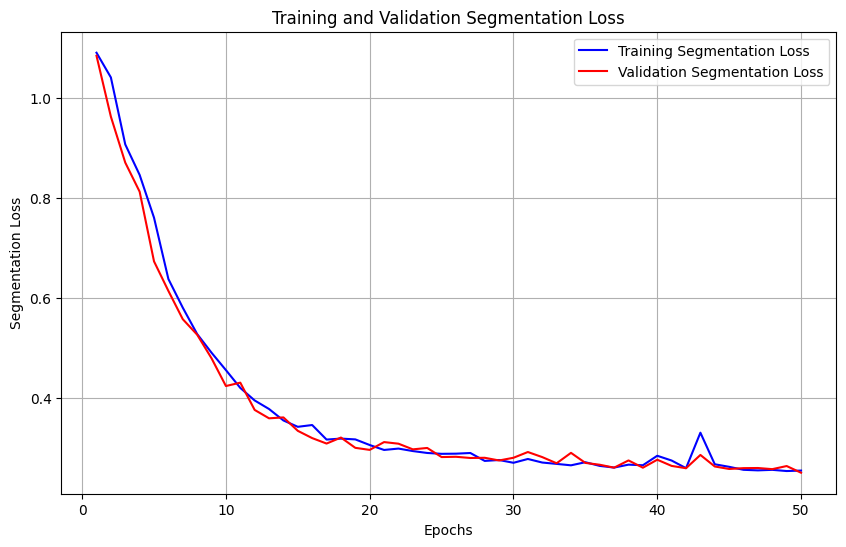

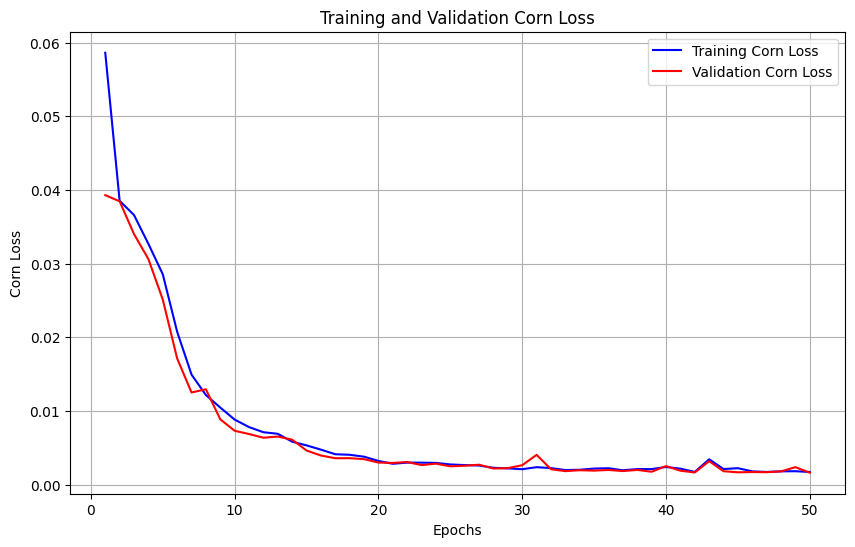

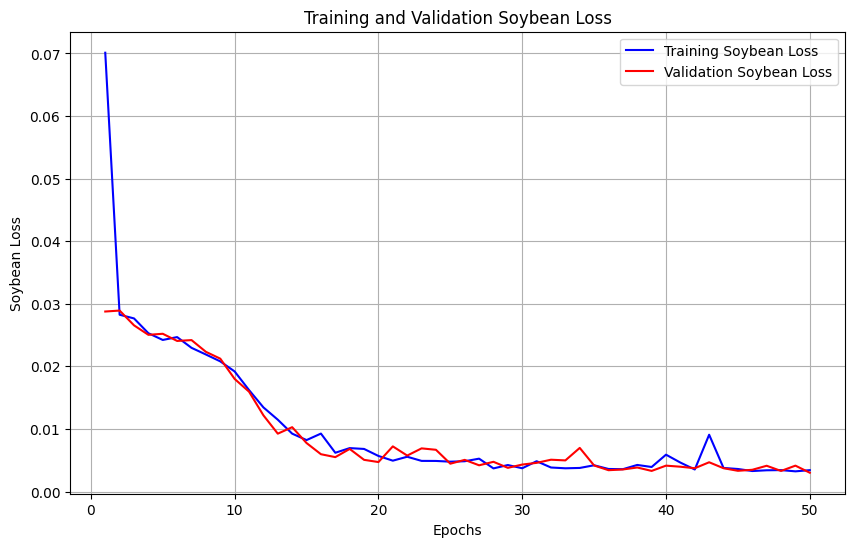

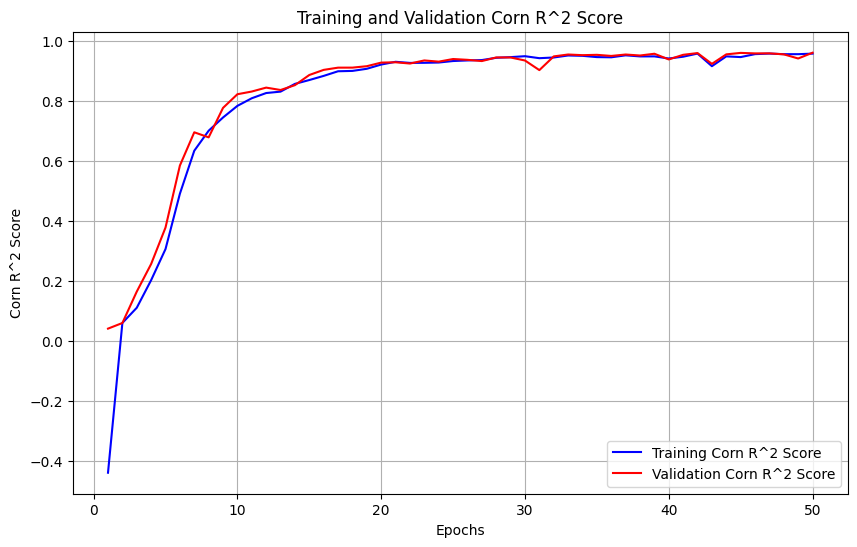

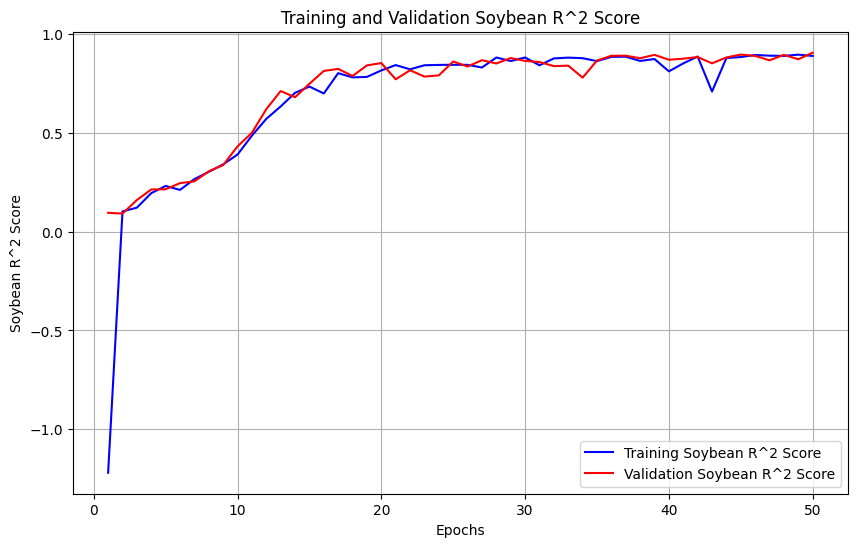

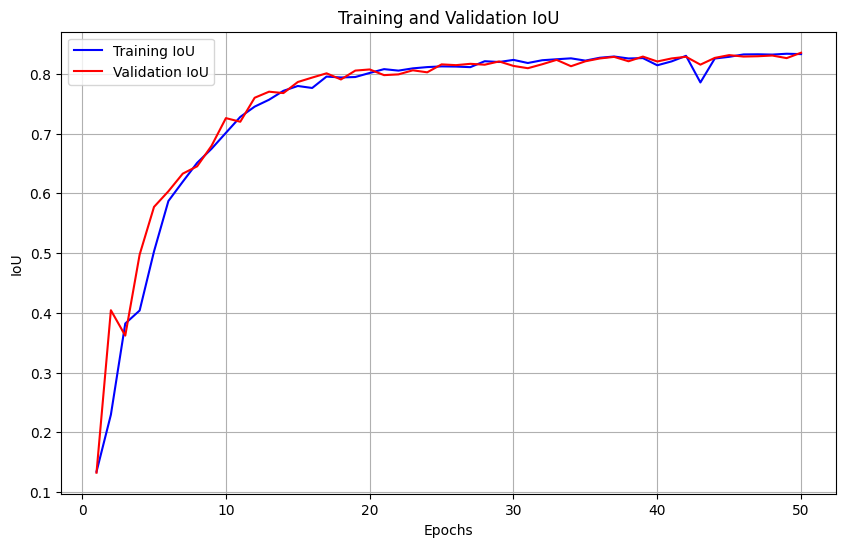

In [21]:
import os
import pandas as pd
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


# Check if CUDA is available and set the default device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Assuming UNetWithYieldEstimation and other necessary elements are defined
model = UNetWithYieldEstimation(in_channels=8, out_channels=3).to(device)
model = nn.DataParallel(model)

# Define loss functions
criterion_segmentation = nn.CrossEntropyLoss()
criterion_regression = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Define Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, checkpoint_dir='checkpoints_unet_no_sig'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.counter = 0
        self.checkpoint_dir = checkpoint_dir

        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

    def __call__(self, val_loss, model, optimizer, epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, epoch):
        """Saves model and optimizer when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        checkpoint_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.module.state_dict(),  # Access the underlying model
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, checkpoint_path)
        self.val_loss_min = val_loss

early_stopper = EarlyStopping(patience=10, verbose=True)

# Define the number of epochs
num_epochs = 50

# Initialize lists to store losses and R² scores
train_losses_seg, val_losses_seg = [], []
train_losses_corn, val_losses_corn = [], []
train_losses_soybean, val_losses_soybean = [], []
train_r2_corn, val_r2_corn = [], []
train_r2_soybean, val_r2_soybean = [], []
train_ious, val_ious = [],[]

# Function to calculate IoU
def calculate_iou(preds, targets, num_classes=3):
    ious = []
    preds = torch.argmax(preds, dim=1).view(-1)
    targets = targets.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).long().sum().item()
        union = (pred_inds | target_inds).long().sum().item()

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)  # Average IoU across classes

# Function to get current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Plotting functions
def plot_losses(train_losses, val_losses, loss_type, filename):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label=f'Training {loss_type} Loss')
    plt.plot(epochs, val_losses, 'r', label=f'Validation {loss_type} Loss')
    plt.xlabel('Epochs')
    plt.ylabel(f'{loss_type} Loss')
    plt.legend()
    plt.title(f'Training and Validation {loss_type} Loss')
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def plot_r2_scores(train_r2, val_r2, crop_type, filename):
    epochs = range(1, len(train_r2) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_r2, 'b', label=f'Training {crop_type} R^2 Score')
    plt.plot(epochs, val_r2, 'r', label=f'Validation {crop_type} R^2 Score')
    plt.xlabel('Epochs')
    plt.ylabel(f'{crop_type} R^2 Score')
    plt.legend()
    plt.title(f'Training and Validation {crop_type} R^2 Score')
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def plot_iou(train_iou, val_iou, filename):
    epochs = range(1, len(train_iou) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_iou, 'b', label='Training IoU')
    plt.plot(epochs, val_iou, 'r', label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('Training and Validation IoU')
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Training and validation loop
with open('checkpoints_unet/loss_log_unet.txt', 'w') as f:
    f.write("Epoch,Train Seg Loss,Train IoU,Val Seg Loss,Val IoU,Train Corn Loss,Train Soybean Loss,Val Corn Loss,Val Soybean Loss,Train Corn R2,Train Soybean R2,Val Corn R2,Val Soybean R2,Learning Rate\n")

    for epoch in range(num_epochs):
        model.train()
        train_loss_seg, train_iou = 0.0, 0.0
        train_loss_corn, train_loss_soybean = 0.0, 0.0
        total_train_r2_corn, total_train_r2_soybean = 0.0, 0.0
        for images, targets, yields in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            corn_yield, soybean_yield = yields
            images, targets = images.to(device).float(), targets.to(device).long()
            corn_yield, soybean_yield = corn_yield.to(device), soybean_yield.to(device)

            optimizer.zero_grad()
            seg_output, pred_corn_yield, pred_soybean_yield = model(images)

            loss_segmentation = criterion_segmentation(seg_output, targets.squeeze(1))  # Squeeze the targets
            loss_corn_yield = criterion_regression(pred_corn_yield.view(-1), corn_yield)
            loss_soybean_yield = criterion_regression(pred_soybean_yield.view(-1), soybean_yield)

            loss = loss_segmentation + loss_corn_yield + loss_soybean_yield
            loss.backward()
            optimizer.step()

            train_loss_seg += loss_segmentation.item()
            train_loss_corn += loss_corn_yield.item()
            train_loss_soybean += loss_soybean_yield.item()
            train_iou += calculate_iou(seg_output, targets)
            total_train_r2_corn += r2_score(corn_yield.cpu().numpy(), pred_corn_yield.view(-1).cpu().detach().numpy())
            total_train_r2_soybean += r2_score(soybean_yield.cpu().numpy(), pred_soybean_yield.view(-1).cpu().detach().numpy())

        train_losses_seg.append(train_loss_seg / len(train_loader))
        train_ious.append(train_iou / len(train_loader))
        train_losses_corn.append(train_loss_corn / len(train_loader))
        train_losses_soybean.append(train_loss_soybean / len(train_loader))
        train_r2_corn.append(total_train_r2_corn / len(train_loader))
        train_r2_soybean.append(total_train_r2_soybean / len(train_loader))

        model.eval()
        val_loss_seg, val_iou = 0.0, 0.0
        val_loss_corn, val_loss_soybean = 0.0, 0.0
        total_val_r2_corn, total_val_r2_soybean = 0.0, 0.0
        with torch.no_grad():
            for images, targets, yields in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                corn_yield, soybean_yield = yields
                images, targets = images.to(device).float(), targets.to(device).long()
                corn_yield, soybean_yield = corn_yield.to(device), soybean_yield.to(device)

                seg_output, pred_corn_yield, pred_soybean_yield = model(images)

                loss_segmentation = criterion_segmentation(seg_output, targets.squeeze(1))  # Squeeze the targets
                loss_corn_yield = criterion_regression(pred_corn_yield.view(-1), corn_yield)
                loss_soybean_yield = criterion_regression(pred_soybean_yield.view(-1), soybean_yield)

                loss = loss_segmentation + loss_corn_yield + loss_soybean_yield
                val_loss_seg += loss_segmentation.item()
                val_loss_corn += loss_corn_yield.item()
                val_loss_soybean += loss_soybean_yield.item()
                val_iou += calculate_iou(seg_output, targets)
                total_val_r2_corn += r2_score(corn_yield.cpu().numpy(), pred_corn_yield.view(-1).cpu().detach().numpy())
                total_val_r2_soybean += r2_score(soybean_yield.cpu().numpy(), pred_soybean_yield.view(-1).cpu().detach().numpy())

        val_losses_seg.append(val_loss_seg / len(val_loader))
        val_ious.append(val_iou / len(val_loader))
        val_losses_corn.append(val_loss_corn / len(val_loader))
        val_losses_soybean.append(val_loss_soybean / len(val_loader))
        val_r2_corn.append(total_val_r2_corn / len(val_loader))
        val_r2_soybean.append(total_val_r2_soybean / len(val_loader))

        current_lr = get_lr(optimizer)

        print(f'Epoch {epoch+1}, Train Seg Loss: {train_losses_seg[-1]:.4f}, Train IoU: {train_ious[-1]:.4f}, Val Seg Loss: {val_losses_seg[-1]:.4f}, Val IoU: {val_ious[-1]:.4f}')
        print(f'          Train Corn Loss: {train_losses_corn[-1]:.4f}, Train Soybean Loss: {train_losses_soybean[-1]:.4f}')
        print(f'          Val Corn Loss: {val_losses_corn[-1]:.4f}, Val Soybean Loss: {val_losses_soybean[-1]:.4f}')
        print(f'          Train Corn R2: {train_r2_corn[-1]:.4f}, Train Soybean R2: {train_r2_soybean[-1]:.4f}')
        print(f'          Val Corn R2: {val_r2_corn[-1]:.4f}, Val Soybean R2: {val_r2_soybean[-1]:.4f}')
        print(f'          Learning Rate: {current_lr:.6f}')

        f.write(f"{epoch+1},{train_losses_seg[-1]:.4f},{train_ious[-1]:.4f},{val_losses_seg[-1]:.4f},{val_ious[-1]:.4f},{train_losses_corn[-1]:.4f},{train_losses_soybean[-1]:.4f},{val_losses_corn[-1]:.4f},{val_losses_soybean[-1]:.4f},{train_r2_corn[-1]:.4f},{train_r2_soybean[-1]:.4f},{val_r2_corn[-1]:.4f},{val_r2_soybean[-1]:.4f},{current_lr:.6f}\n")

        # Save checkpoint every epoch
        early_stopper.save_checkpoint(val_losses_seg[-1], model, optimizer, epoch)

        # Step the scheduler
        scheduler.step(val_losses_seg[-1])

        # Early stopping check
        early_stopper(val_losses_seg[-1], model, optimizer, epoch)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

# Plotting the losses and R2 scores
plot_losses(train_losses_seg, val_losses_seg, 'Segmentation', 'checkpoints_unet_no_sig/train_val_segmentation_loss.png')
plot_losses(train_losses_corn, val_losses_corn, 'Corn', 'checkpoints_unet_no_sig/train_val_corn_loss.png')
plot_losses(train_losses_soybean, val_losses_soybean, 'Soybean', 'checkpoints_unet_no_sig/train_val_soybean_loss.png')
plot_r2_scores(train_r2_corn, val_r2_corn, 'Corn', 'checkpoints_unet_no_sig/train_val_corn_r2.png')
plot_r2_scores(train_r2_soybean, val_r2_soybean, 'Soybean', 'checkpoints_unet_no_sig/train_val_soybean_r2.png')
plot_iou(train_ious, val_ious, 'checkpoints_unet_no_sig/train_val_iou.png')


Loaded checkpoint from epoch 49 with validation loss 0.2511
Test Loss: 0.3286, Test IoU: 0.7734
Test Pixel Accuracy: 0.8871
Test Mean Pixel Accuracy: 0.8751
Test Dice Coefficient: 0.8705
Test Corn Loss: 0.0036
Test Soybean Loss: 0.0068
R^2 Score for Corn Yield: 0.9210
R^2 Score for Soybean Yield: 0.7375


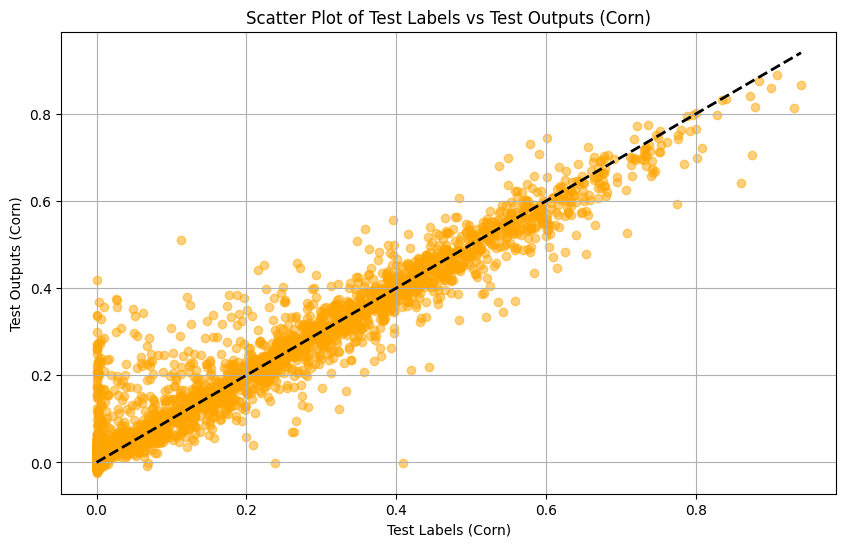

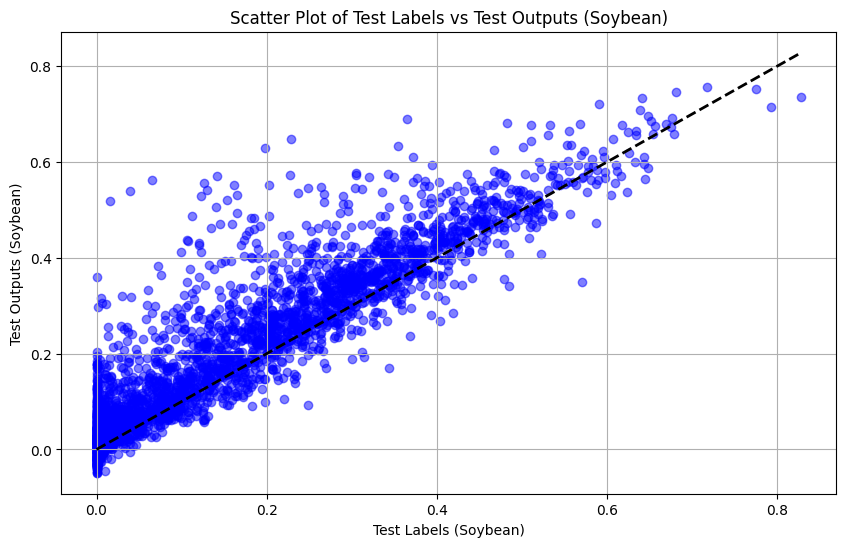

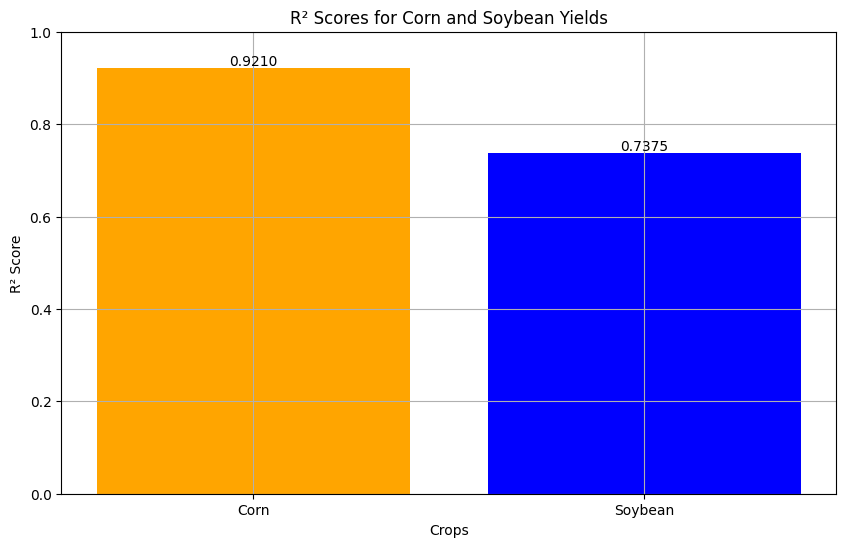

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd  # Add this import

def load_checkpoint(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['model_state_dict']

    # Check if the model is wrapped in nn.DataParallel
    if 'module.' in list(state_dict.keys())[0]:
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                new_state_dict[k[7:]] = v
            else:
                new_state_dict[k] = v
        model.load_state_dict(new_state_dict)
    else:
        # Model was not wrapped in nn.DataParallel during training
        new_state_dict = {}
        for k, v in state_dict.items():
            new_state_dict[f'module.{k}'] = v
        model.load_state_dict(new_state_dict)

    print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.4f}")

def pixel_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    total = target.numel()
    return correct / total

def mean_pixel_accuracy(output, target, num_classes):
    _, predicted = torch.max(output, 1)
    mean_acc = 0
    for i in range(num_classes):
        class_mask = (target == i)
        correct = ((predicted == i) & class_mask).sum().item()
        total = class_mask.sum().item()
        if total == 0:
            continue
        mean_acc += correct / total
    return mean_acc / num_classes

def dice_coefficient(output, target, num_classes=3):
    smooth = 1e-6
    _, predicted = torch.max(output, 1)
    dice = 0.0

    for i in range(num_classes):
        pred_i = (predicted == i).float()
        target_i = (target == i).float()
        intersection = (pred_i * target_i).sum().item()
        union = pred_i.sum().item() + target_i.sum().item()
        dice += (2. * intersection + smooth) / (union + smooth)
    
    return dice / num_classes

def evaluate_model(model, test_loader, device):
    model.eval()

    # Define metrics to track
    test_loss = 0.0
    test_iou = 0.0
    test_pixel_acc = 0.0
    test_mean_pixel_acc = 0.0
    test_dice = 0.0
    test_corn_loss = 0.0
    test_soybean_loss = 0.0
    test_segmentation_criterion = nn.CrossEntropyLoss()
    test_regression_criterion = nn.MSELoss()
    num_classes = 3  # Adjust based on your specific number of classes

    # Tracking arrays for yield predictions and actual yields
    all_pred_corn_yields = []
    all_true_corn_yields = []
    all_pred_soybean_yields = []
    all_true_soybean_yields = []

    # Add index tracking
    indices = []

    # Testing loop
    with torch.no_grad():
        for idx, (images, targets, yields) in enumerate(test_loader):
            corn_yield, soybean_yield = yields
            images, targets = images.to(device).float(), targets.to(device).long()
            corn_yield, soybean_yield = corn_yield.to(device), soybean_yield.to(device)

            # Remove the channel dimension from targets
            targets = targets.squeeze(1)

            seg_output, pred_corn_yield, pred_soybean_yield = model(images)

            # Ensure predicted yields retain their dimensions
            pred_corn_yield = pred_corn_yield.view(-1)
            pred_soybean_yield = pred_soybean_yield.view(-1)

            loss_segmentation = test_segmentation_criterion(seg_output, targets)
            loss_corn_yield = test_regression_criterion(pred_corn_yield, corn_yield)
            loss_soybean_yield = test_regression_criterion(pred_soybean_yield, soybean_yield)

            loss = loss_segmentation +  loss_corn_yield +  loss_soybean_yield
            test_loss += loss.item()
            test_iou += calculate_iou(seg_output, targets)
            test_pixel_acc += pixel_accuracy(seg_output, targets)
            test_mean_pixel_acc += mean_pixel_accuracy(seg_output, targets, num_classes)
            test_dice += dice_coefficient(seg_output, targets)
            test_corn_loss += loss_corn_yield.item()
            test_soybean_loss += loss_soybean_yield.item()

            # Store predictions, actual yields, and indices
            all_pred_corn_yields.extend(pred_corn_yield.cpu().numpy())
            all_true_corn_yields.extend(corn_yield.cpu().numpy())
            all_pred_soybean_yields.extend(pred_soybean_yield.cpu().numpy())
            all_true_soybean_yields.extend(soybean_yield.cpu().numpy())
            indices.extend([idx] * len(pred_corn_yield))

    # Calculate average test loss and metrics
    test_loss /= len(test_loader)
    test_iou /= len(test_loader)
    test_pixel_acc /= len(test_loader)
    test_mean_pixel_acc /= len(test_loader)
    test_dice /= len(test_loader)
    test_corn_loss /= len(test_loader)
    test_soybean_loss /= len(test_loader)

    print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')
    print(f'Test Pixel Accuracy: {test_pixel_acc:.4f}')
    print(f'Test Mean Pixel Accuracy: {test_mean_pixel_acc:.4f}')
    print(f'Test Dice Coefficient: {test_dice:.4f}')
    print(f'Test Corn Loss: {test_corn_loss:.4f}')
    print(f'Test Soybean Loss: {test_soybean_loss:.4f}')

    # Calculate R² score for yield predictions
    r2_corn = r2_score(all_true_corn_yields, all_pred_corn_yields)
    r2_soybean = r2_score(all_true_soybean_yields, all_pred_soybean_yields)

    print(f'R^2 Score for Corn Yield: {r2_corn:.4f}')
    print(f'R^2 Score for Soybean Yield: {r2_soybean:.4f}')

    # Save predictions to CSV
    results_df = pd.DataFrame({
        'Index': indices,
        'True_Corn_Yield': all_true_corn_yields,
        'Predicted_Corn_Yield': all_pred_corn_yields,
        'True_Soybean_Yield': all_true_soybean_yields,
        'Predicted_Soybean_Yield': all_pred_soybean_yields
    })
    results_df.to_csv('checkpoints_unet_no_sig/predictions_unet_no_seg.csv', index=False)

    return (all_true_corn_yields, all_pred_corn_yields,
            all_true_soybean_yields, all_pred_soybean_yields,
            r2_corn, r2_soybean)

def plot_scatter(true_values, pred_values, crop_type, filename):
    plt.figure(figsize=(10, 6))
    color = 'orange' if crop_type == 'Corn' else 'blue'
    plt.scatter(true_values, pred_values, color=color, alpha=0.5)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', linewidth=2)
    plt.title(f'Scatter Plot of Test Labels vs Test Outputs ({crop_type})')
    plt.xlabel(f'Test Labels ({crop_type})')
    plt.ylabel(f'Test Outputs ({crop_type})')
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def plot_r2_scores(r2_corn, r2_soybean, filename):
    crops = ['Corn', 'Soybean']
    r2_scores = [r2_corn, r2_soybean]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(crops, r2_scores, color=['orange', 'blue'])
    plt.xlabel('Crops')
    plt.ylabel('R² Score')
    plt.title('R² Scores for Corn and Soybean Yields')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')
    
    plt.ylim(0, 1)  # Set y-axis limit to range [0, 1]
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Assuming 'model', 'test_loader', 'device' are defined, and the model is already loaded with the best weights
model = UNetWithYieldEstimation(in_channels=8, out_channels=3).to(device)
model = nn.DataParallel(model)
checkpoint_path = 'checkpoints_unet_no_sig/checkpoint_epoch_49.pth'
load_checkpoint(model, checkpoint_path, device)

(all_true_corn_yields, all_pred_corn_yields,
 all_true_soybean_yields, all_pred_soybean_yields,
 r2_corn, r2_soybean) = evaluate_model(model, test_loader, device)

# Plot the results
plot_scatter(all_true_corn_yields, all_pred_corn_yields, 'Corn', 'checkpoints_unet_no_sig/test_labels_vs_outputs_corn.png')
plot_scatter(all_true_soybean_yields, all_pred_soybean_yields, 'Soybean', 'checkpoints_unet_no_sig/test_labels_vs_outputs_soybean.png')
plot_r2_scores(r2_corn, r2_soybean, 'checkpoints_unet_no_sig/test_r2_scores.png')


In [10]:
# test on MN23

In [15]:
#test on test6 Minnesota 2023

img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/img_dir/test6"
ann_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6"
crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6/normalized_test_yield.csv"
dataset_test = CombinedDataset(img_test, ann_test,crop_test, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True, pin_memory=True)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
# Function to calculate IoU
def calculate_iou(preds, targets, num_classes=3):
    ious = []
    preds = torch.argmax(preds, dim=1).view(-1)
    targets = targets.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).long().sum().item()
        union = (pred_inds | target_inds).long().sum().item()

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)  # Average IoU across classes


Using device: cuda


Loaded checkpoint from epoch 49 with validation loss 0.2511
Test Loss: 0.4418, Test IoU: 0.7194
Test Pixel Accuracy: 0.8476
Test Mean Pixel Accuracy: 0.8340
Test Dice Coefficient: 0.8342
Test Corn Loss: 0.0063
Test Soybean Loss: 0.0070
R^2 Score for Corn Yield: 0.8364
R^2 Score for Soybean Yield: 0.6515


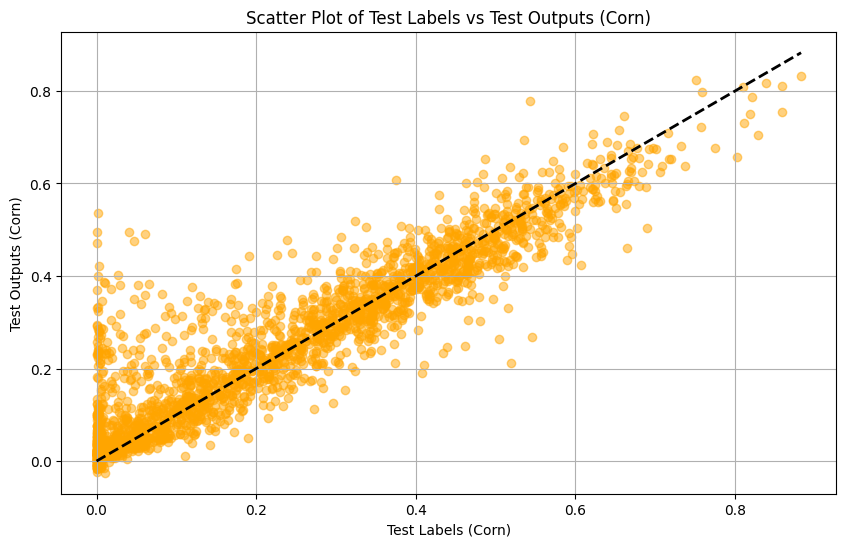

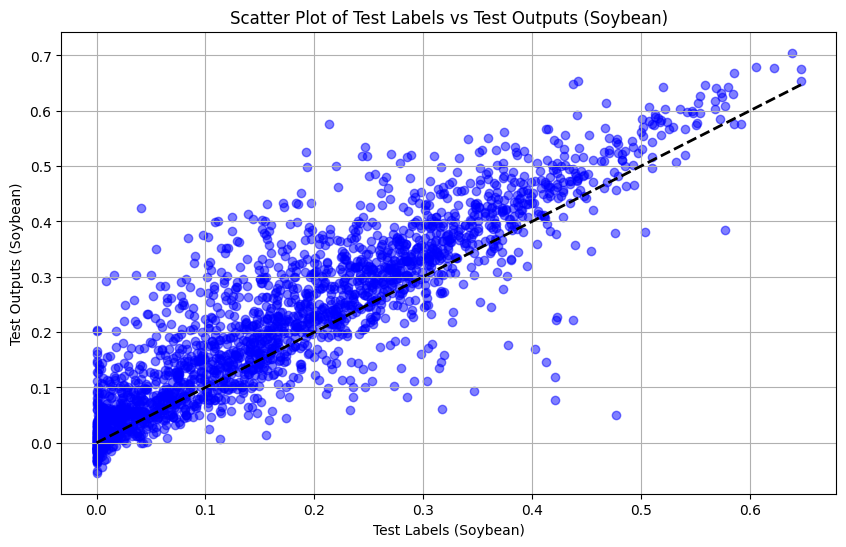

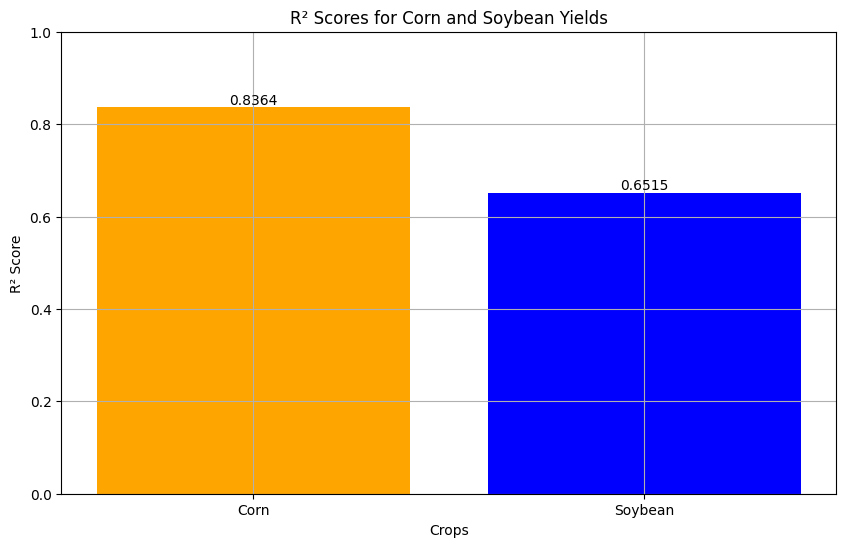

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd  # Add this import

def load_checkpoint(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['model_state_dict']

    # Check if the model is wrapped in nn.DataParallel
    if 'module.' in list(state_dict.keys())[0]:
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                new_state_dict[k[7:]] = v
            else:
                new_state_dict[k] = v
        model.load_state_dict(new_state_dict)
    else:
        # Model was not wrapped in nn.DataParallel during training
        new_state_dict = {}
        for k, v in state_dict.items():
            new_state_dict[f'module.{k}'] = v
        model.load_state_dict(new_state_dict)

    print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.4f}")

def pixel_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    total = target.numel()
    return correct / total

def mean_pixel_accuracy(output, target, num_classes):
    _, predicted = torch.max(output, 1)
    mean_acc = 0
    for i in range(num_classes):
        class_mask = (target == i)
        correct = ((predicted == i) & class_mask).sum().item()
        total = class_mask.sum().item()
        if total == 0:
            continue
        mean_acc += correct / total
    return mean_acc / num_classes

def dice_coefficient(output, target, num_classes=3):
    smooth = 1e-6
    _, predicted = torch.max(output, 1)
    dice = 0.0

    for i in range(num_classes):
        pred_i = (predicted == i).float()
        target_i = (target == i).float()
        intersection = (pred_i * target_i).sum().item()
        union = pred_i.sum().item() + target_i.sum().item()
        dice += (2. * intersection + smooth) / (union + smooth)
    
    return dice / num_classes

def evaluate_model(model, test_loader, device):
    model.eval()

    # Define metrics to track
    test_loss = 0.0
    test_iou = 0.0
    test_pixel_acc = 0.0
    test_mean_pixel_acc = 0.0
    test_dice = 0.0
    test_corn_loss = 0.0
    test_soybean_loss = 0.0
    test_segmentation_criterion = nn.CrossEntropyLoss()
    test_regression_criterion = nn.MSELoss()
    num_classes = 3  # Adjust based on your specific number of classes

    # Tracking arrays for yield predictions and actual yields
    all_pred_corn_yields = []
    all_true_corn_yields = []
    all_pred_soybean_yields = []
    all_true_soybean_yields = []

    # Add index tracking
    indices = []

    # Testing loop
    with torch.no_grad():
        for idx, (images, targets, yields) in enumerate(test_loader):
            corn_yield, soybean_yield = yields
            images, targets = images.to(device).float(), targets.to(device).long()
            corn_yield, soybean_yield = corn_yield.to(device), soybean_yield.to(device)

            # Remove the channel dimension from targets
            targets = targets.squeeze(1)

            seg_output, pred_corn_yield, pred_soybean_yield = model(images)

            # Ensure predicted yields retain their dimensions
            pred_corn_yield = pred_corn_yield.view(-1)
            pred_soybean_yield = pred_soybean_yield.view(-1)

            loss_segmentation = test_segmentation_criterion(seg_output, targets)
            loss_corn_yield = test_regression_criterion(pred_corn_yield, corn_yield)
            loss_soybean_yield = test_regression_criterion(pred_soybean_yield, soybean_yield)

            loss = loss_segmentation +  loss_corn_yield +  loss_soybean_yield
            test_loss += loss.item()
            test_iou += calculate_iou(seg_output, targets)
            test_pixel_acc += pixel_accuracy(seg_output, targets)
            test_mean_pixel_acc += mean_pixel_accuracy(seg_output, targets, num_classes)
            test_dice += dice_coefficient(seg_output, targets)
            test_corn_loss += loss_corn_yield.item()
            test_soybean_loss += loss_soybean_yield.item()

            # Store predictions, actual yields, and indices
            all_pred_corn_yields.extend(pred_corn_yield.cpu().numpy())
            all_true_corn_yields.extend(corn_yield.cpu().numpy())
            all_pred_soybean_yields.extend(pred_soybean_yield.cpu().numpy())
            all_true_soybean_yields.extend(soybean_yield.cpu().numpy())
            indices.extend([idx] * len(pred_corn_yield))

    # Calculate average test loss and metrics
    test_loss /= len(test_loader)
    test_iou /= len(test_loader)
    test_pixel_acc /= len(test_loader)
    test_mean_pixel_acc /= len(test_loader)
    test_dice /= len(test_loader)
    test_corn_loss /= len(test_loader)
    test_soybean_loss /= len(test_loader)

    print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')
    print(f'Test Pixel Accuracy: {test_pixel_acc:.4f}')
    print(f'Test Mean Pixel Accuracy: {test_mean_pixel_acc:.4f}')
    print(f'Test Dice Coefficient: {test_dice:.4f}')
    print(f'Test Corn Loss: {test_corn_loss:.4f}')
    print(f'Test Soybean Loss: {test_soybean_loss:.4f}')

    # Calculate R² score for yield predictions
    r2_corn = r2_score(all_true_corn_yields, all_pred_corn_yields)
    r2_soybean = r2_score(all_true_soybean_yields, all_pred_soybean_yields)

    print(f'R^2 Score for Corn Yield: {r2_corn:.4f}')
    print(f'R^2 Score for Soybean Yield: {r2_soybean:.4f}')

    # Save predictions to CSV
    results_df = pd.DataFrame({
        'Index': indices,
        'True_Corn_Yield': all_true_corn_yields,
        'Predicted_Corn_Yield': all_pred_corn_yields,
        'True_Soybean_Yield': all_true_soybean_yields,
        'Predicted_Soybean_Yield': all_pred_soybean_yields
    })
    results_df.to_csv('checkpoints_unet_no_sig/predictions_unet_no_seg_MN23.csv', index=False)

    return (all_true_corn_yields, all_pred_corn_yields,
            all_true_soybean_yields, all_pred_soybean_yields,
            r2_corn, r2_soybean)

def plot_scatter(true_values, pred_values, crop_type, filename):
    plt.figure(figsize=(10, 6))
    color = 'orange' if crop_type == 'Corn' else 'blue'
    plt.scatter(true_values, pred_values, color=color, alpha=0.5)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', linewidth=2)
    plt.title(f'Scatter Plot of Test Labels vs Test Outputs ({crop_type})')
    plt.xlabel(f'Test Labels ({crop_type})')
    plt.ylabel(f'Test Outputs ({crop_type})')
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def plot_r2_scores(r2_corn, r2_soybean, filename):
    crops = ['Corn', 'Soybean']
    r2_scores = [r2_corn, r2_soybean]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(crops, r2_scores, color=['orange', 'blue'])
    plt.xlabel('Crops')
    plt.ylabel('R² Score')
    plt.title('R² Scores for Corn and Soybean Yields')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')
    
    plt.ylim(0, 1)  # Set y-axis limit to range [0, 1]
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Assuming 'model', 'test_loader', 'device' are defined, and the model is already loaded with the best weights
model = UNetWithYieldEstimation(in_channels=8, out_channels=3).to(device)
model = nn.DataParallel(model)
checkpoint_path = 'checkpoints_unet_no_sig/checkpoint_epoch_49.pth'
load_checkpoint(model, checkpoint_path, device)

(all_true_corn_yields, all_pred_corn_yields,
 all_true_soybean_yields, all_pred_soybean_yields,
 r2_corn, r2_soybean) = evaluate_model(model, test_loader, device)

# Plot the results
plot_scatter(all_true_corn_yields, all_pred_corn_yields, 'Corn', 'checkpoints_unet_no_sig/test_labels_vs_outputs_corn_MN23.png')
plot_scatter(all_true_soybean_yields, all_pred_soybean_yields, 'Soybean', 'checkpoints_unet_no_sig/test_labels_vs_outputs_soybean_MN23.png')
plot_r2_scores(r2_corn, r2_soybean, 'checkpoints_unet_no_sig/test_r2_scores_MN23.png')


Using device: cuda


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap

# Ensure the directory for saving images exists
output_dir = 'checkpoints_unet_multi_head/visualizations'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define a custom colormap
cmap = ListedColormap(['black', 'orange', 'blue'])

# Function to visualize sample predictions alongside their ground truth labels
def visualize_predictions(images, targets, outputs, num_samples=3, rgb_channels=(5, 3, 2), output_dir='visualizations'):
    images_np = images.cpu().detach().numpy()
    targets_np = targets.cpu().detach().numpy()
    outputs_np = outputs.cpu().detach().numpy()

    num_samples = min(num_samples, len(images_np))  # Ensure num_samples is not greater than the dataset size

    # Randomly select samples
    sample_indices = np.random.choice(len(images_np), num_samples, replace=False)

    for idx in sample_indices:
        image = images_np[idx]  # Multiply pixel values by 10000
        target = targets_np[idx]
        output = np.argmax(outputs_np[idx], axis=0)

        # Concatenate channels to create RGB image
        rgb_image = np.transpose(image, (1, 2, 0))[:, :, rgb_channels]

        plt.figure(figsize=(15, 5))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(rgb_image)
        plt.title("Original Image (x10000)")
        plt.axis('off')

        # Plot ground truth
        plt.subplot(1, 3, 2)
        plt.imshow(target, cmap=cmap, vmin=0, vmax=2)
        plt.title("Ground Truth")
        plt.axis('off')

        # Plot predicted output
        plt.subplot(1, 3, 3)
        plt.imshow(output, cmap=cmap, vmin=0, vmax=2)
        plt.title("Predicted Output")
        plt.axis('off')

        # Save the figure
        save_path = os.path.join(output_dir, f'prediction_{idx}.png')
        plt.savefig(save_path)
        plt.close()

# Visualize sample predictions using specific RGB channels
# visualize_predictions(images, targets, outputs, rgb_channels=(5, 3, 2))

model.eval()
with torch.no_grad():
    for images, targets, yields in test_loader:
        images, targets = images.to(device).float(), targets.to(device).long()
        targets = targets.squeeze(1)  # Remove the channel dimension from targets
        outputs, pred_corn_yield, pred_soybean_yield = model(images)
        
        visualize_predictions(images, targets, outputs, num_samples=5, rgb_channels=(5, 3, 2), output_dir=output_dir)
        break  # Remove this line if you want to visualize more batches
